In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import datetime as dt
from math import sqrt

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import missingno as msno
%matplotlib inline

# Stats libraries
from scipy import stats
from scipy.stats import ttest_ind
from lifetimes import BetaGeoFitter

# Machine Learning libraries
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


In [2]:
sheet1_data = pd.read_excel('../data/online_retail_II.xlsx', sheet_name='Year 2009-2010')
sheet2_data = pd.read_excel('../data/online_retail_II.xlsx', sheet_name='Year 2010-2011')

In [3]:
retail = pd.concat([sheet1_data, sheet2_data], ignore_index=True)
retail.shape

(1067371, 8)

# <span style="color:teal;">Overview: Business Understanding</span>

A UK company offers unique all-occasion gifts like themed dishware and household items. They've had over 1 million transactions from 2009-2011, mainly supplying products to wholesalers, retail stores, and resellers. The high-volume periods are the UK's peak holiday seasons, from October to December.

## <span style="color:teal;">Objective</span>

The main challenge is to understand customer data and past sales. The goal is to:
1. Identify opportunities to create targeted marketing segments.
2. Forecast sales efficiently.

### <span style="color:teal;">Additional Considerations</span>

The analysis also factors in cancellations and returns. The segmentation should pinpoint customers less likely to return or cancel orders, aiming to ensure profitable sales and enhance the company's profitability.


---


# <span style="color:teal;">Data Understanding</span>

The data set, named "Online Retail II", comes from the UCI Machine Learning Repository. It captures transactions from a UK-based online retail business between 2009 and 2011, with 1,067,371 records and 8 features. The primary focus of the company is unique all-occasion gift-ware, and many of its customers are wholesalers.

#### <span style="color:teal;">Variable Information:</span>

- **Invoice (object)**: Unique 6-digit number for each transaction. Prefix 'c' indicates cancellations.
- **StockCode (object)**: 5-digit code representing each product.
- **Description (object)**: Name of the product.
- **Quantity (int64)**: Amount of each product in a transaction.
- **InvoiceDate (datetime)**: Timestamp of the transaction.
- **Price (float64)**: Product price per unit in sterling (£).
- **CustomerID (int64)**: 5-digit identifier for each customer.
- **Country (object)**: Customer's country of residence.


Random Sample of Data:
       Invoice StockCode                          Description  Quantity  \
924358  571265     22533     MAGIC DRAWING SLATE BAKE A CAKE          2   
879741  567873     84991          60 TEATIME FAIRY CAKE CASES        24   
994436  576563     23300   GARDENERS KNEELING PAD CUP OF TEA          2   
961893  574143     22734   SET OF 6 RIBBONS VINTAGE CHRISTMAS        11   
704674  552265     22219   LOVEBIRD HANGING DECORATION WHITE          6   
770988  558614     20618   QUEEN OF THE SKIES PASSPORT COVER          1   
353863  523792     35961     FOLKART ZINC HEART CHRISTMAS DEC         2   
597713  542237     20966                 SANDWICH BATH SPONGE        10   
866293  566720     23119        PACK OF 6 LARGE FRUIT STRAWS          2   
376132  525744     22867              HAND WARMER BIRD DESIGN        48   
44870   493393     22278   OVERNIGHT BAG VINTAGE ROSE PAISLEY         6   
789884  560093     23013        GLASS APOTHECARY BOTTLE TONIC         4   
23

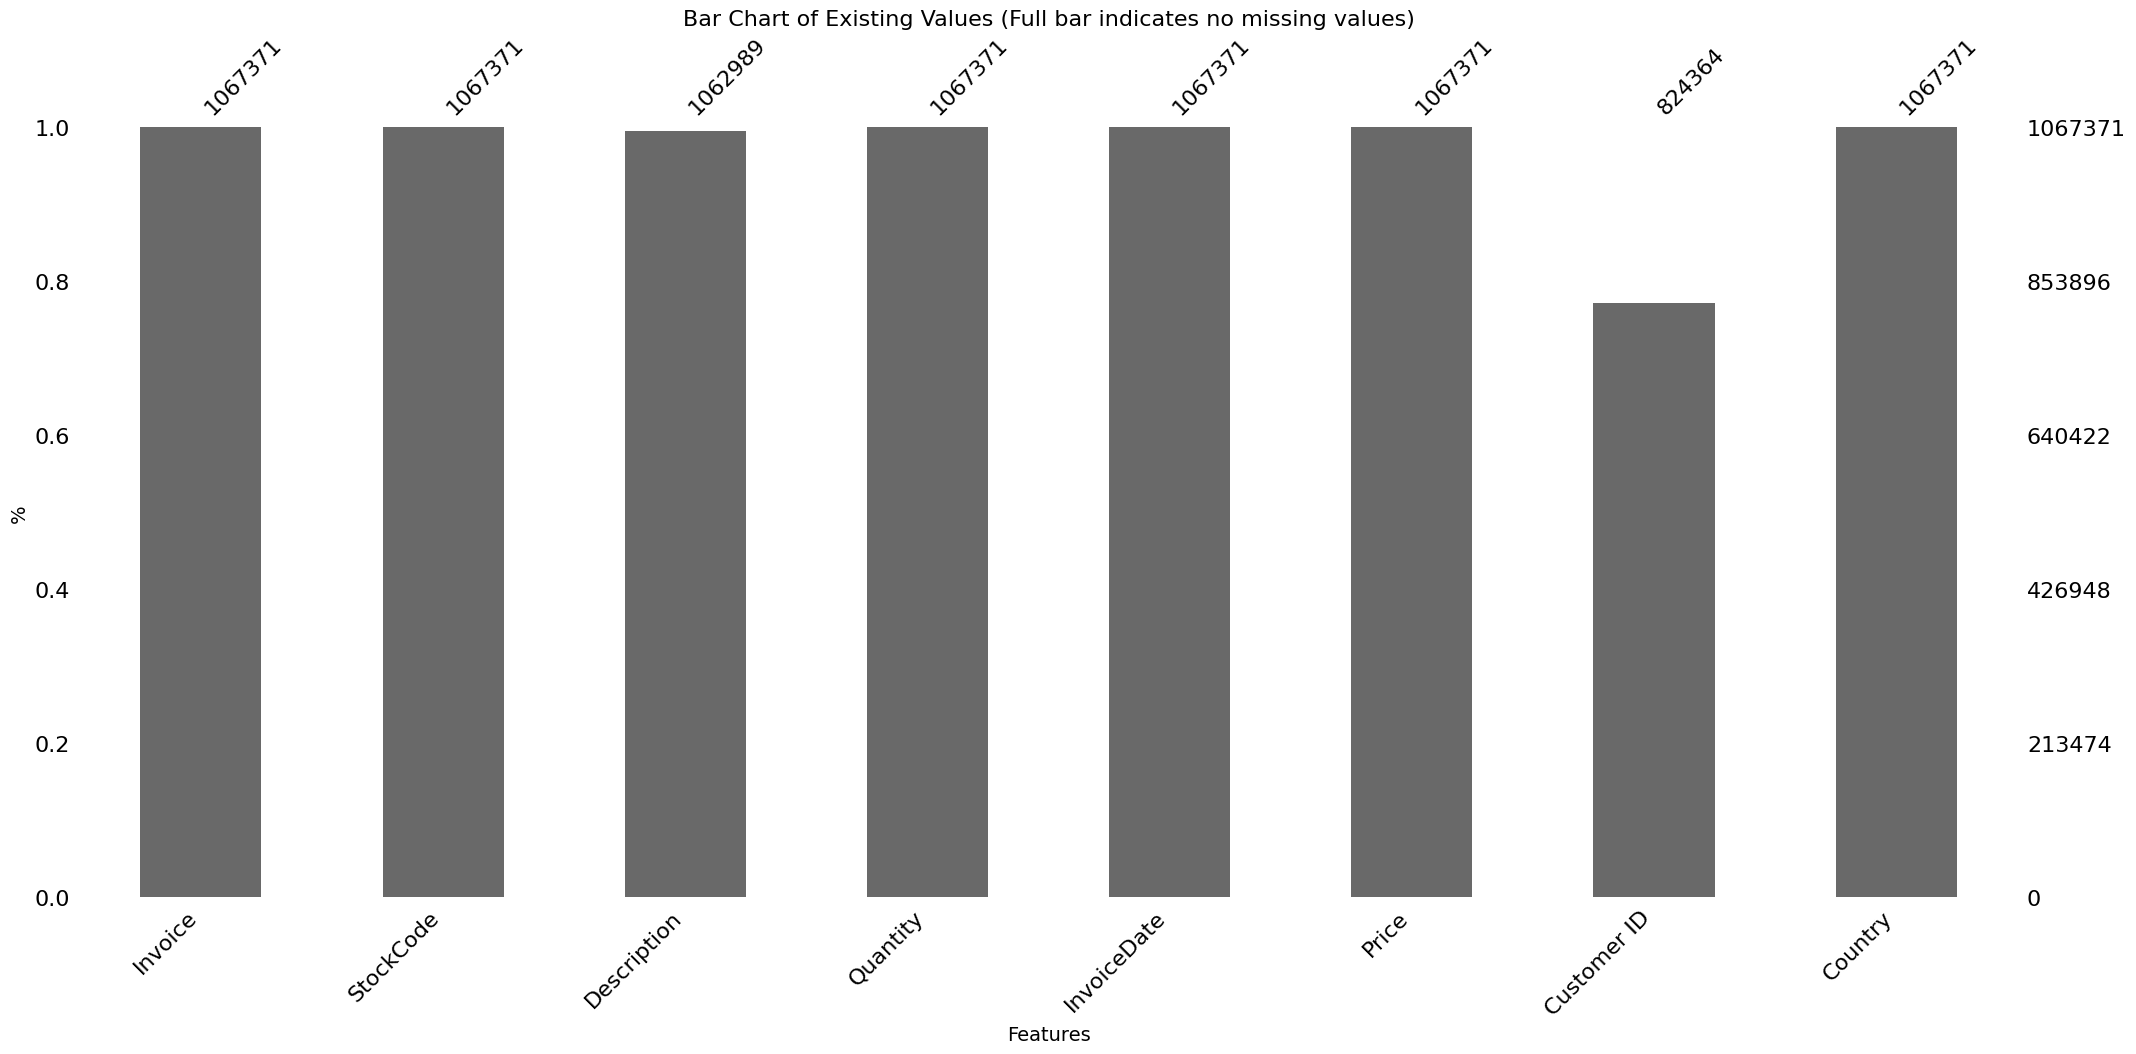

Dendrogram (groups columns that have strong NULL correlation):


<Figure size 800x600 with 0 Axes>

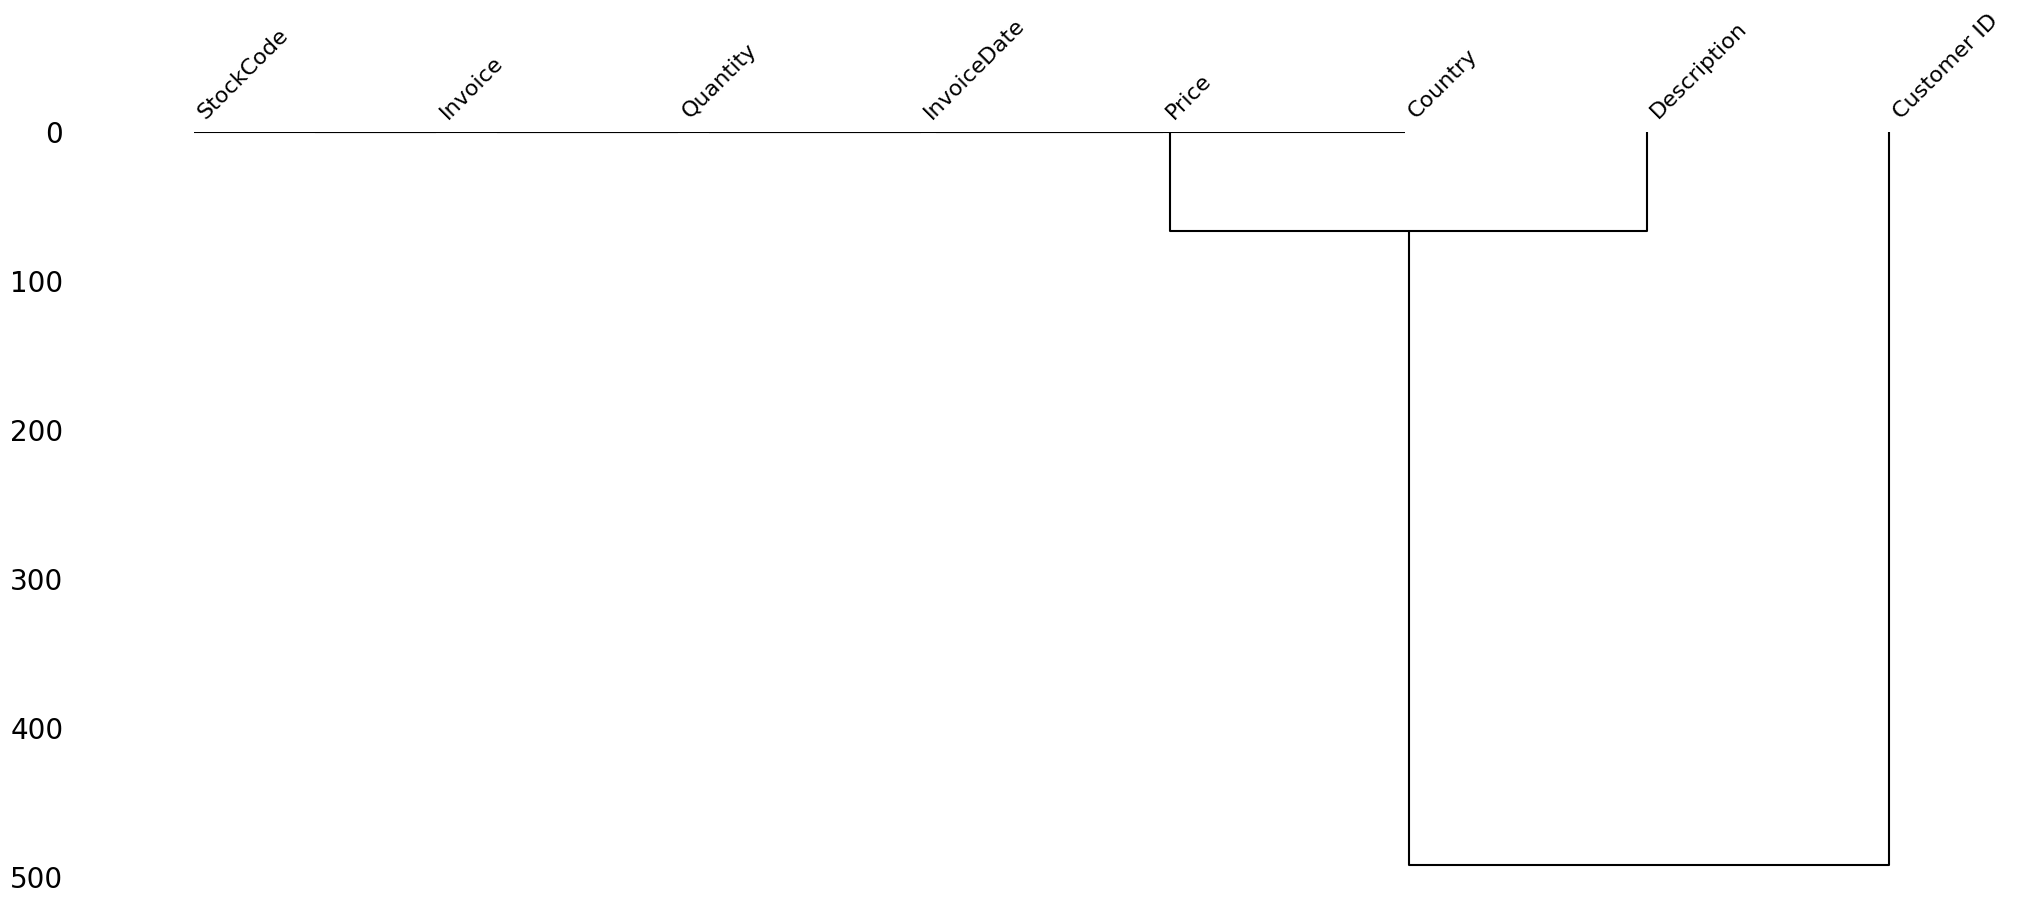

In [4]:
# Set display options for Pandas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

def data_intro(data):
    """
    Display introductory data analysis for a DataFrame.

    Args:
        data (pandas DataFrame): The DataFrame to be analyzed.
    """
    # Display a random sample of data
    print("\033[4mRandom Sample of Data:\033[0m")
    print(data.sample(20), '\n')

    # Display data information
    print("\033[4mData Info:\033[0m")
    print(data.info(), '\n')

    # Display basic statistics for numeric features
    print("\033[4mBasic Statistics for Numeric Features:\033[0m")
    print(data.describe(include=np.number).T, '\n')

    # Display NULL value examination
    null_percentage = 100 * data.isnull().sum() / len(data)
    print("\033[4mNULL Value Examination (%):\033[0m")
    print(round(null_percentage, 2), '\n')

    # Display a bar chart of existing values
    print("\033[4mBar Chart of Existing Values (Full bar indicates no missing values):\033[0m")
    plt.figure(figsize=(12, 6))
    plt.title('Bar Chart of Existing Values (Full bar indicates no missing values)', fontsize=16)
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('%', fontsize=14)
    msno.bar(data)
    plt.show()

    # Display a dendrogram of NULL correlations
    print("\033[4mDendrogram (groups columns that have strong NULL correlation):\033[0m")
    plt.figure(figsize=(8, 6))
    msno.dendrogram(data)
    plt.show()

# Call the data_intro function with your DataFrame df
data_intro(retail)


## <span style="color:teal;">Observations</span>

### <span style="color:teal;">Missing Values</span>
- `Customer ID` contains roughly 23% NULL values.
- `Description` contains about 0.41% NULL values.

### <span style="color:teal;">Quantity</span>
- The `Quantity` column:
  - Shows high variability with a standard deviation of 172.71 and a mean of 9.94.
  - Has a positively skewed distribution.
  - Contains negative values, suggesting data cleaning requirements.
- Implications:
  - Varying purchasing quantities reveal inconsistent purchasing behaviors.
  - There may be a need to either eliminate outliers or normalize data.
- Significance:
  - Essential for understanding purchasing patterns.
  - Holds significance for inventory, sales predictions, marketing, and price setting.

### <span style="color:teal;">Price</span>
- The `Price` column:
  - Exhibits high variability with a standard deviation of 123.55 and an average price of $4.65.
  - Contains negative values which must be addressed during data cleaning.
- Implications:
  - Variations might arise due to differing product categories, offers, or discounts.
- Significance:
  - Crucial for cost assessment, pricing tactics, and determining market price sensitivity.
  - May warrant outlier removal and normalization.

### <span style="color:teal;">Invoice Cancellations</span>
- The `Invoice` column has entries starting with "C" that denote cancellations. These should be removed.

## <span style="color:teal;">Additional Macros</span>

For further analysis, it would be beneficial to:
- Ascertain the start and end date for the dataset.
- Enumerate the unique countries and their occurrences.
- Compute the count of distinct item descriptions.
- Count the different stock codes.
- Establish the number of unique invoices.
- Determine instances in the `Quantity` and `Price` columns that are less than or equal to 0.
- Identify the highest number of return occurrences.


In [5]:
import locale

def format_number(num):
    # Format numbers with commas for thousands separator
    return locale.format_string("%.2f", num, grouping=True)

def macro_eda(data):
    """
    Basic business overview of data.

    Args:
        data (pandas dataframe): The dataframe containing the data.
    """
    # Set locale for formatting
    locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

    # Start and End date of data:
    date_range = data['InvoiceDate'].agg(['min', 'max'])
    print(f"- Transactions range: {date_range[0]} to {date_range[1]}")

    # Number of unique countries and Top 10 country representation
    unique_country_count = data['Country'].nunique()
    country_representation = (data['Country'].value_counts(normalize=True) * 100).head(10)
    print(f"- # Unique Countries: {format_number(unique_country_count)}")
    print(f"- % Country Representation:\n{country_representation.apply(format_number)}\n")

    # Number of unique Descriptions
    # ! note that this may not be accurate b/c text has not been normalized
    unique_description_count = data['Description'].nunique()
    description_representation = (data['Description'].value_counts(normalize=True) * 100).head(10)
    print(f"- # Unique Descriptions Approximate (text was not normalized): {format_number(unique_description_count)}")
    
    # Number of unique Stock Codes
    unique_stock_code_count = data['StockCode'].nunique()
    print(f"- # Unique Stock Codes: {format_number(unique_stock_code_count)}")

    # Number of unique Invoices
    unique_invoice_count = data['Invoice'].nunique()
    print(f"- # Unique Invoices: {format_number(unique_invoice_count)}")

    # % of values in Quantity and Price cols <= 0
    quantity_percentage = round((data['Quantity'] <= 0).mean() * 100, 2)
    price_percentage = round((data['Price'] <= 0).mean() * 100, 2)
    print(f"- % values in Quantity column (<=0): {format_number(quantity_percentage)}")
    print(f"- % values in Price column (<=0): {format_number(price_percentage)}")

    # Number of maximum returns (Invoices that start with "C"):
    count_c_in_invoice = data[data["Invoice"].str.startswith("C", na=False)].shape[0]
    print(f"- # Invoices that are returns: {format_number(count_c_in_invoice)}")

macro_eda(retail)

- Transactions range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00
- # Unique Countries: 43.00
- % Country Representation:
United Kingdom    91.94
EIRE               1.67
Germany            1.65
France             1.34
Netherlands        0.48
Spain              0.36
Switzerland        0.30
Belgium            0.29
Portugal           0.25
Australia          0.18
Name: Country, dtype: object

- # Unique Descriptions Approximate (text was not normalized): 5,698.00
- # Unique Stock Codes: 5,305.00
- # Unique Invoices: 53,628.00
- % values in Quantity column (<=0): 2.15
- % values in Price column (<=0): 0.58
- # Invoices that are returns: 19,494.00


### <span style="color:teal;">Key Takeaways:</span>

#### <span style="color:teal;">Transactions Range</span>
- Transactions span from December 1, 2009, at 07:45 AM to December 9, 2011, at 12:50 PM.

#### <span style="color:teal;">Countries</span>
- The dataset includes data from 43 distinct countries.
- The United Kingdom dominates with 91.94% of all transactions.
- Other prominent countries include EIRE (1.67%), Germany (1.65%), France (1.34%), and the Netherlands (0.48%).

#### <span style="color:teal;">Product Descriptions</span>
- The dataset contains 5,698 distinct product descriptions, showcasing a wide variety of products.

#### <span style="color:teal;">Invoices</span>
- The dataset comprises 53,628 unique invoices, reflecting the number of orders or sales.

#### <span style="color:teal;">Quantity and Price Columns</span>
- About 2.15% of entries in the "Quantity" column have values ≤ 0, possibly indicating returns or data discrepancies.
- Roughly 0.58% of "Price" column entries have values ≤ 0, potentially signaling data issues.

#### <span style="color:teal;">Returns</span>
- 19,494 invoices are marked as returns and might need exclusion for accurate analysis.

---


# <span style="color:teal;">Data Preprocessing</span>

**Caveat**: Some data cleaning steps, like normalizing columns like 'Descriptions', might be beneficial in other contexts. However, since our focus is on RFM variations, we'll bypass such steps.

## <span style="color:teal;">Cleaning Steps:</span>
1. Remove rows with NULL values.
2. Eliminate duplicate rows.
3. Omit rows where:
   - `Quantity` ≤ 0.
   - `Price` ≤ 0.
   - `Invoice` begins with "C" (indicating returns).
4. Introduce a new column, `Monetary`, computed as: 
   ```python
   Monetary = Quantity * Price


In [6]:
def data_transformation(data):
    # Drop null/empty values
    data.dropna(inplace=True)

    # Convert "Invoice" column to strings
    data['Invoice'] = data['Invoice'].astype(str)

    # Drop duplicates
    data.drop_duplicates(inplace=True)

    # Filter for Quantity or Price are > 0
    data = data[(data['Quantity'] > 0) & (data['Price'] > 0)]

    # Create a new DataFrame with the 'Monetary' column
    new_data = data.copy()
    new_data['Monetary'] = new_data['Quantity'] * new_data['Price']

    # Drop Invoices that begin with "C"
    new_data = new_data.loc[~new_data['Invoice'].str.startswith('C', na=False)]

    return new_data


retail2 = data_transformation(retail)

Random Sample of Data:
        Invoice StockCode                          Description  Quantity  \
955366   573576     23194           GYMKHANA TREASURE BOOK BOX         1   
277788   516432     22079           RIBBON REEL HEARTS DESIGN         30   
210233   509686     21621           VINTAGE UNION JACK BUNTING         1   
125634   501426     84937             KASHMIR FOLKART TUMBLERS        36   
201020   508721     21466        RED FLOWER CROCHET FOOD COVER         1   
386496   526564    85199L  LARGE HANGING IVORY & RED WOOD BIRD         7   
329878   521557     79067                  CORONA MEXICAN TRAY         4   
4656     489824     22127        PARTY CONES CARNIVAL ASSORTED         6   
18094    490926    85123A   WHITE HANGING HEART T-LIGHT HOLDER        10   
1026310  578811     22635     CHILDS BREAKFAST SET DOLLY GIRL          8   
361361   524365    84970L     SINGLE HEART ZINC T-LIGHT HOLDER        12   
466650   533369    85129D      BEADED CRYSTAL HEART PINK SMALL   

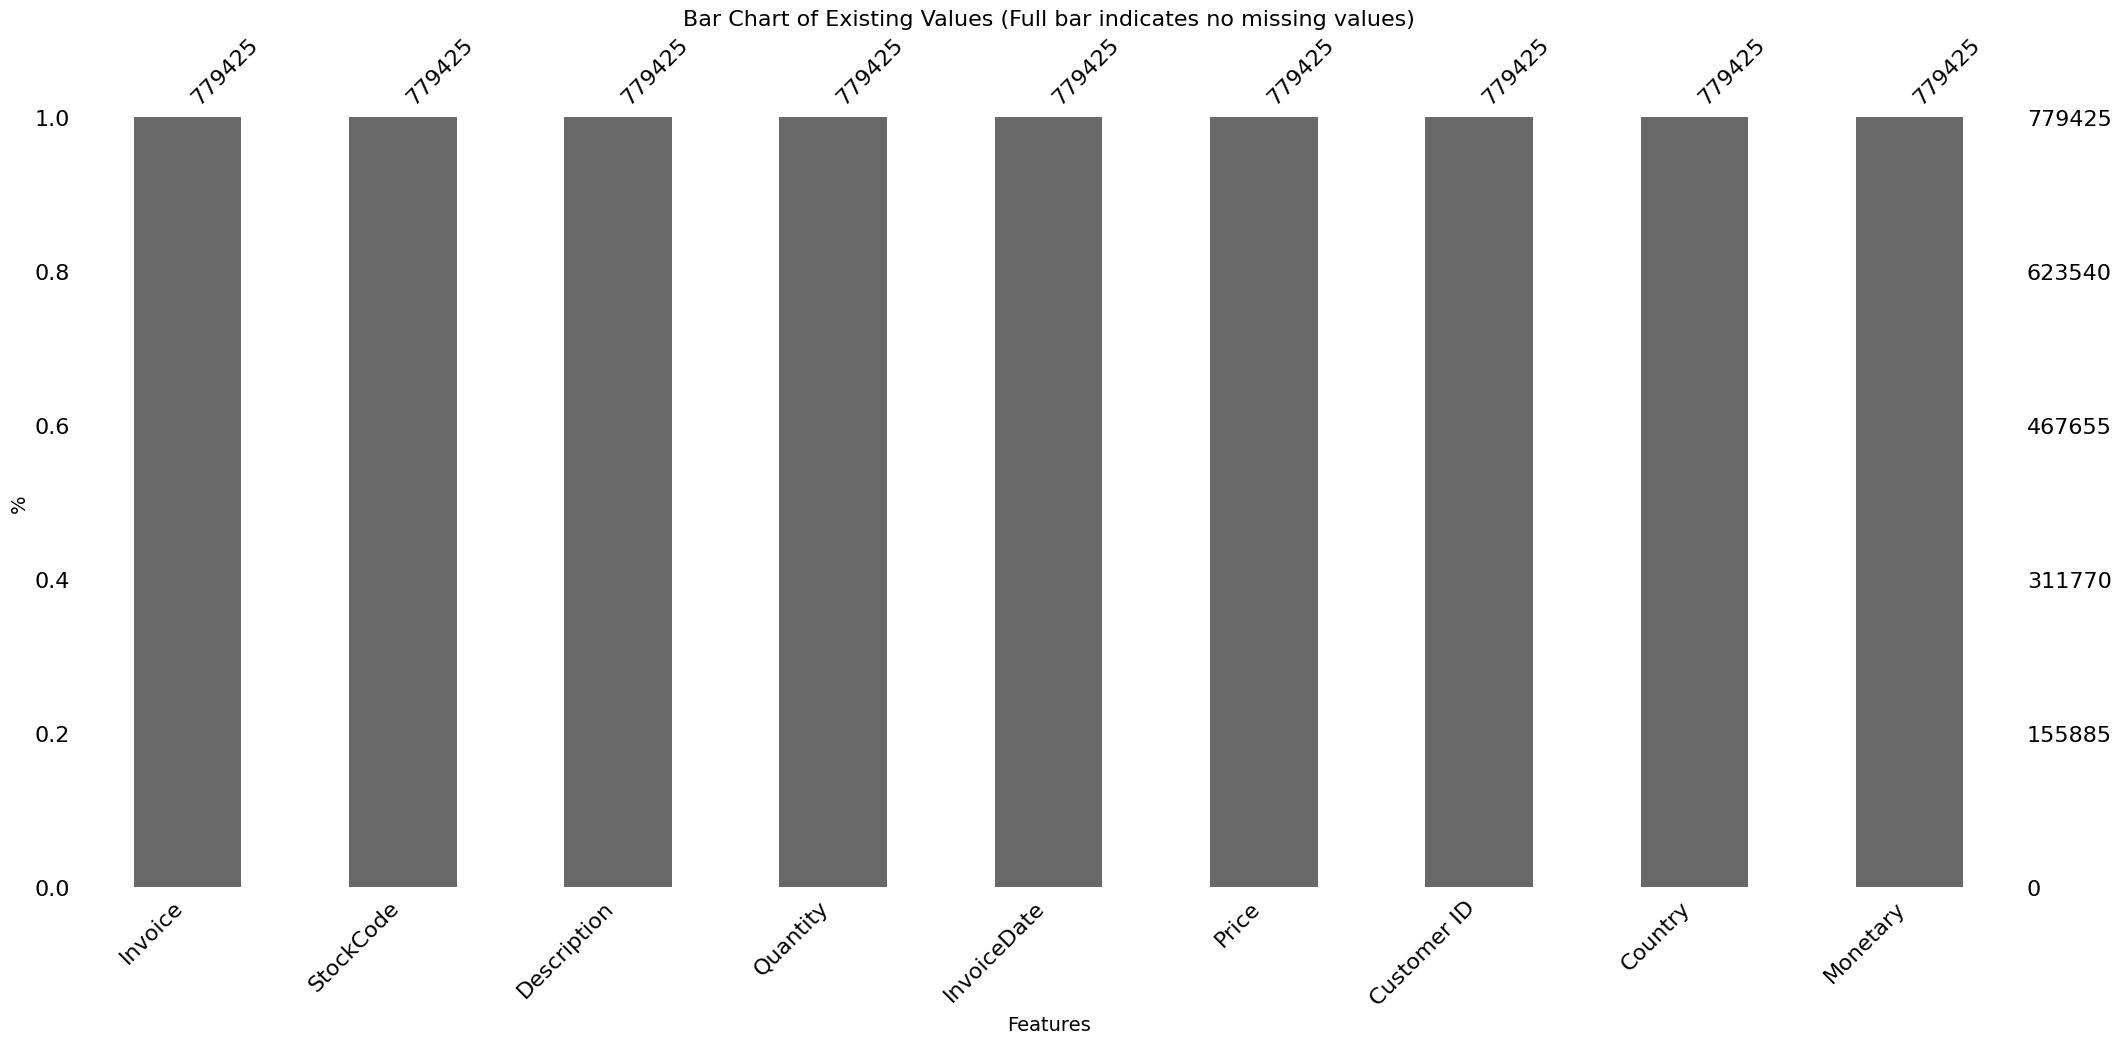

Dendrogram (groups columns that have strong NULL correlation):


C:\Users\Kunal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\cluster\hierarchy.py:2848: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([dvw, 0])


<Figure size 800x600 with 0 Axes>

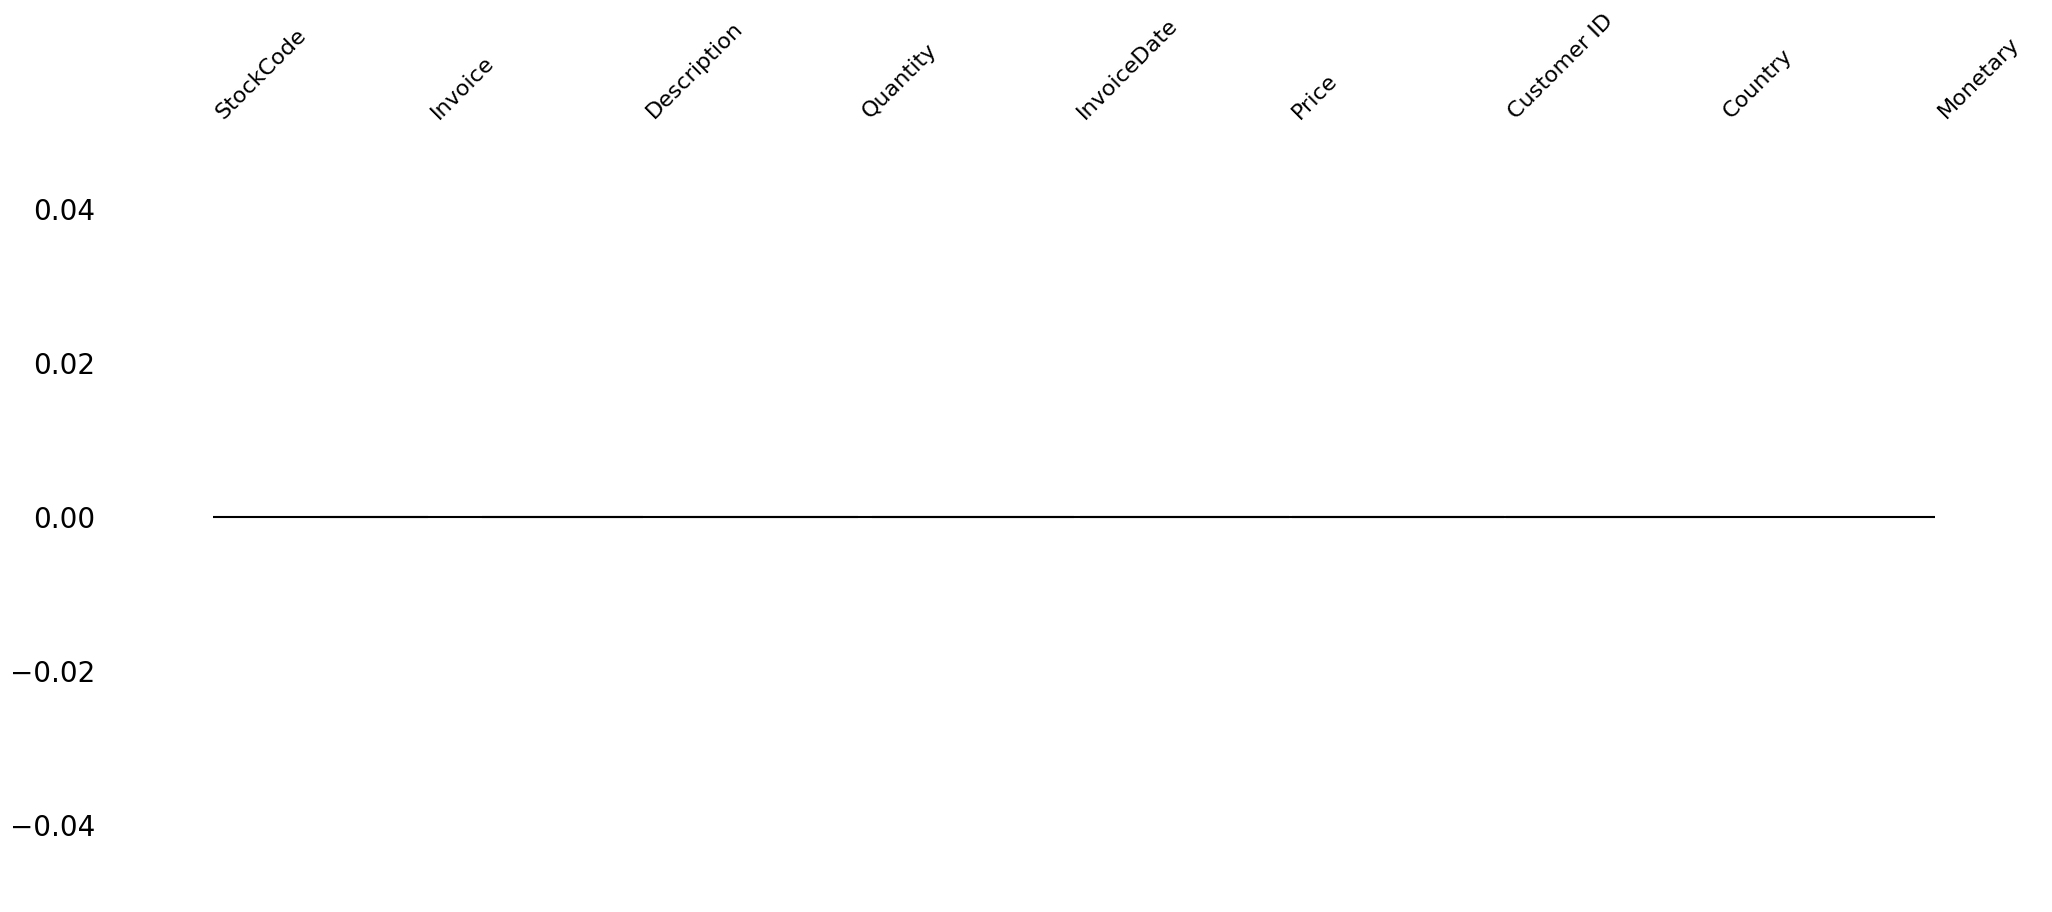

In [7]:
data_intro(retail2)
# below we can see that our dataset is cleaner, however we did not yet scale values. That will come later.

---
## <span style="color:teal;">Exploratory Data Analysis:</span>

- Distribution of Total Transactions 
- Monetary Spend
- Orders and Average Revenue per Order
- Cohort Analysis:
    - Retention Rates
    - Average Quantity by Cohort

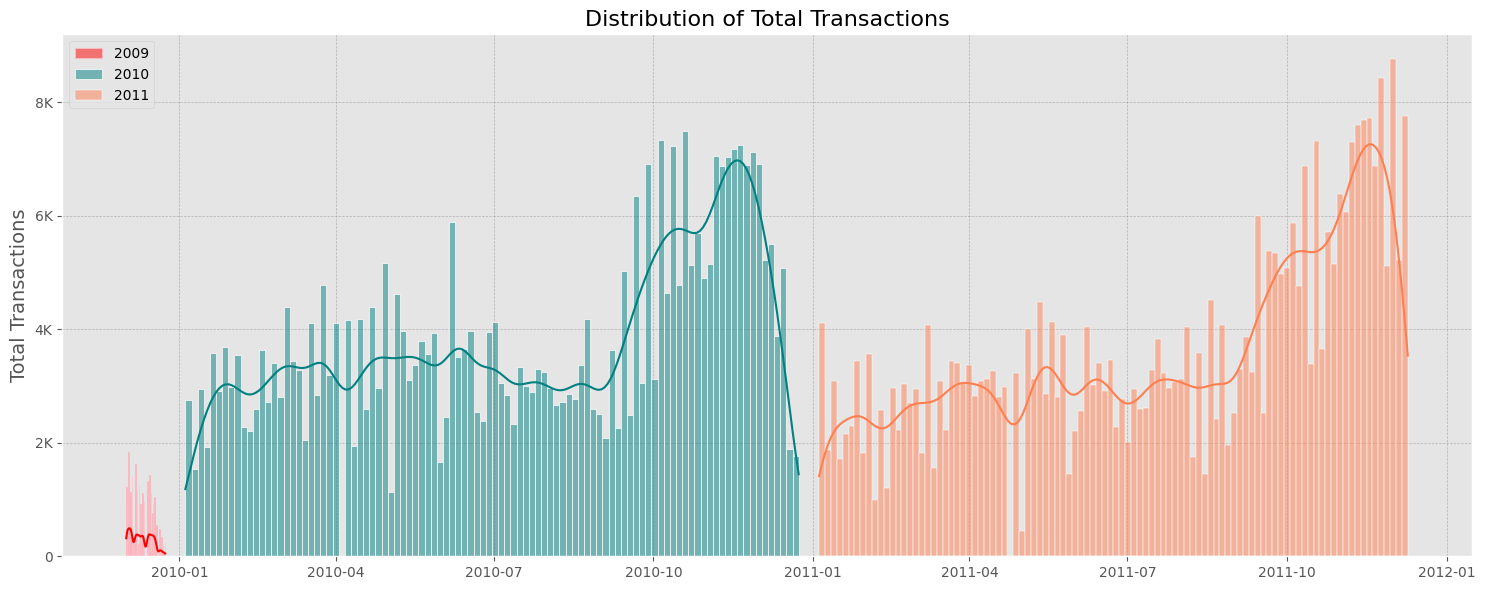

T-statistic: 0.25
P-value: 0.8049
There's no statistically significant difference in monthly transactions between 2010 and 2011.


In [8]:
# Setting the style for the plots
plt.style.use("ggplot")

# Create a copy of retail2
retail3 = retail2.copy()

# Custom function for formatting Y-axis labels
def custom_formatter(x, pos):
    if x >= 1e6:
        return f'{x/1e6:.1f}M' if x % 1e6 else f'{int(x/1e6)}M'
    elif x >= 1e3:
        return f'{x/1e3:.1f}K' if x % 1e3 else f'{int(x/1e3)}K'
    return f'{int(x)}'

# Convert 'InvoiceDate' to datetime and extract time intervals
retail3['InvoiceDate'] = pd.to_datetime(retail3['InvoiceDate'])
retail3['Year'] = retail3['InvoiceDate'].dt.year
retail3['Month'] = retail3['InvoiceDate'].dt.month

# Plotting the distribution of transactions
plt.figure(figsize=(15, 6))
ax = sns.histplot(data=retail3[retail3['Year'] == 2009], x='InvoiceDate', bins=100, color="red", kde=True, edgecolor="pink", label='2009')
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
sns.histplot(data=retail3[retail3['Year'] == 2010], x='InvoiceDate', bins=100, color="teal", kde=True, edgecolor="white", label='2010')
sns.histplot(data=retail3[retail3['Year'] == 2011], x='InvoiceDate', bins=100, color="coral", kde=True, edgecolor="white", label='2011')

# Setting plot details
ax.yaxis.set_major_formatter(ticker.FuncFormatter(custom_formatter))
plt.title("Distribution of Total Transactions", fontsize=16)
ax.set_xlabel("")
plt.ylabel("Total Transactions", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

# Aggregating data by month and running the t-test
monthly_2010 = retail3[retail3['Year'] == 2010].groupby('Month').size()
monthly_2011 = retail3[retail3['Year'] == 2011].groupby('Month').size()
t_stat, p_value = ttest_ind(monthly_2010, monthly_2011)

# Displaying t-test results
print(f"T-statistic: {round(t_stat,4)}")
print(f"P-value: {round(p_value,4)}")

# Interpretation
alpha = 0.05
result_message = "The difference in monthly transactions between 2010 and 2011 is statistically significant." if p_value < alpha else "There's no statistically significant difference in monthly transactions between 2010 and 2011."
print(result_message)


### <span style="color:teal;">Analysis:</span>

#### <span style="color:teal;">Visualization</span>
- 2011 generally experienced higher average monthly transactions compared to 2010. 
- Both years showed cyclical patterns:
  - Clear transaction surges around mid-year.
  - Declines at the beginning of the year.
- 2011 had more pronounced fluctuations:
  - Transactions ranged from lows of around 2K to highs nearing 8K.
  - More pronounced peaks and valleys in the transaction trends.
- A potential outlier is the sharp surge observed in late 2010.
- The data for both years imply recurring seasonal influences on transactions.

#### <span style="color:teal;">t-test</span>
- The T-statistic value of 0.25 reveals a minor difference in the monthly transaction averages between 2010 and 2011.
- With a P-value of 0.8049, which exceeds the threshold of 0.05, this difference isn't deemed statistically significant.
- Therefore, there isn't robust evidence to assert a notable difference in monthly transactions between the two years. The observed variations could simply be a result of random variability.


In [9]:
retail3['CohortMonth'] = retail3['InvoiceDate'].dt.to_period('M').astype(str)
monetary_sum_by_yr = retail3.groupby(['Year','CohortMonth'])['Monetary'].sum().reset_index()
monetary_sum_by_yr

Year CohortMonth   Monetary
0   2009     2009-12  683504.01
1   2010     2010-01  555802.67
2   2010     2010-02  504558.96
3   2010     2010-03  696978.47
4   2010     2010-04  591982.00
5   2010     2010-05  597833.38
6   2010     2010-06  636371.13
7   2010     2010-07  589736.17
8   2010     2010-08  602224.60
9   2010     2010-09  829013.95
10  2010     2010-10 1033112.01
11  2010     2010-11 1166460.02
12  2010     2010-12  570422.73
13  2011     2011-01  568101.31
14  2011     2011-02  446084.92
15  2011     2011-03  594081.76
16  2011     2011-04  468374.33
17  2011     2011-05  677355.15
18  2011     2011-06  660046.05
19  2011     2011-07  598962.90
20  2011     2011-08  644051.04
21  2011     2011-09  950690.20
22  2011     2011-10 1035642.45
23  2011     2011-11 1156205.61
24  2011     2011-12  517208.44

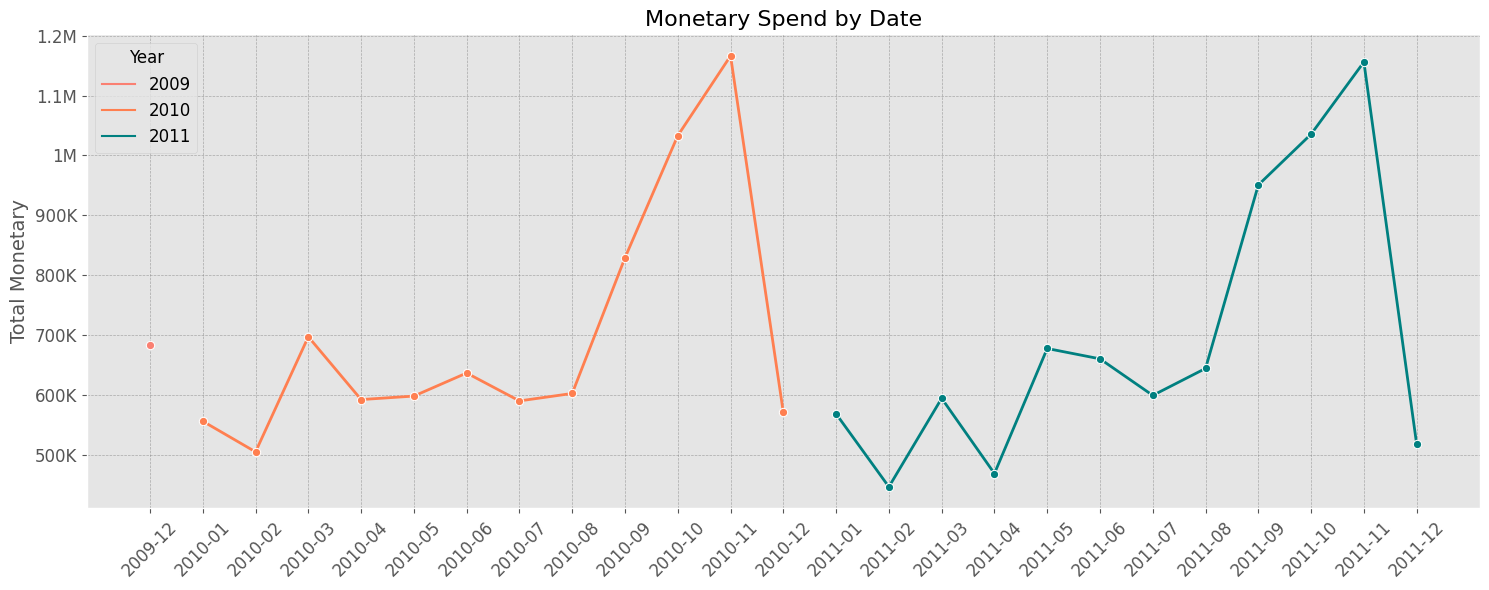

T-statistic: 0.054
P-value: 0.9574
There's no statistically significant difference in monthly Monetary values between 2010 and 2011.


In [10]:
plt.style.use("ggplot")
plt.figure(figsize=(15, 6))
custom_palette = {2009:'salmon', 2010: 'coral', 2011: 'teal'}
ax = sns.lineplot(data=monetary_sum_by_yr, x='CohortMonth', y='Monetary', hue='Year', marker='o', palette=custom_palette, lw=2)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
plt.title("Monetary Spend by Date", fontsize=16)
plt.ylabel("Total Monetary", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
ax.set_xlabel("")
plt.yticks(fontsize=12)
plt.legend(title="Year", title_fontsize=12, fontsize=12, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Aggregating Monetary value by month
monetary_2010 = monetary_sum_by_yr[monetary_sum_by_yr['Year'] == 2010].groupby('CohortMonth')['Monetary'].sum()
monetary_2011 = monetary_sum_by_yr[monetary_sum_by_yr['Year'] == 2011].groupby('CohortMonth')['Monetary'].sum()

# Running the t-test
t_stat, p_value = ttest_ind(monetary_2010, monetary_2011)

print(f"T-statistic: {round(t_stat,4)}")
print(f"P-value: {round(p_value,4)}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("The difference in monthly Monetary values between 2010 and 2011 is statistically significant.")
else:
    print("There's no statistically significant difference in monthly Monetary values between 2010 and 2011.")


### <span style="color:teal;">Analysis:</span>

- **2010's Spending Pattern**:
  - Monetary expenditure during 2010 shows mild variations.
  - A distinct rise can be observed around March.
  - This is followed by a steep drop, a gradual increase, and then a sharp decline as the year concludes.

- **2011's Spending Pattern**:
  - The year commences with modest spending.
  - A remarkable surge in expenditure is noted around the middle of the year.
  - This peak is succeeded by a steady decline for the remaining year.

- **Statistical Insights**:
  - Though 2011 had instances of higher spending than 2010, statistical tests reveal:
    - **T-statistic**: 0.05397
    - **P-value**: 0.9574
  - Consequently, there isn't a statistically significant discrepancy in the monthly monetary spends between 2010 and 2011. This implies that the visible contrasts might just be outcomes of random fluctuations.


In [11]:
# Group the data by 'CohortMonth' and calculate the average monthly revenue
avg_rev_per_order = retail3.groupby('CohortMonth').agg({'Monetary': 'sum', 'Invoice': 'nunique'}).reset_index()
avg_rev_per_order['avg_rev_per_order'] = avg_rev_per_order['Monetary'] / avg_rev_per_order['Invoice']
print(avg_rev_per_order)

   CohortMonth   Monetary  Invoice  avg_rev_per_order
0      2009-12  683504.01     1512             452.05
1      2010-01  555802.67     1011             549.76
2      2010-02  504558.96     1104             457.03
3      2010-03  696978.47     1524             457.33
4      2010-04  591982.00     1329             445.43
5      2010-05  597833.38     1377             434.16
6      2010-06  636371.13     1497             425.10
7      2010-07  589736.17     1381             427.04
8      2010-08  602224.60     1293             465.76
9      2010-09  829013.95     1689             490.83
10     2010-10 1033112.01     2133             484.35
11     2010-11 1166460.02     2587             450.89
12     2010-12  570422.73     1400             407.44
13     2011-01  568101.31      987             575.58
14     2011-02  446084.92      997             447.43
15     2011-03  594081.76     1321             449.72
16     2011-04  468374.33     1149             407.64
17     2011-05  677355.15   

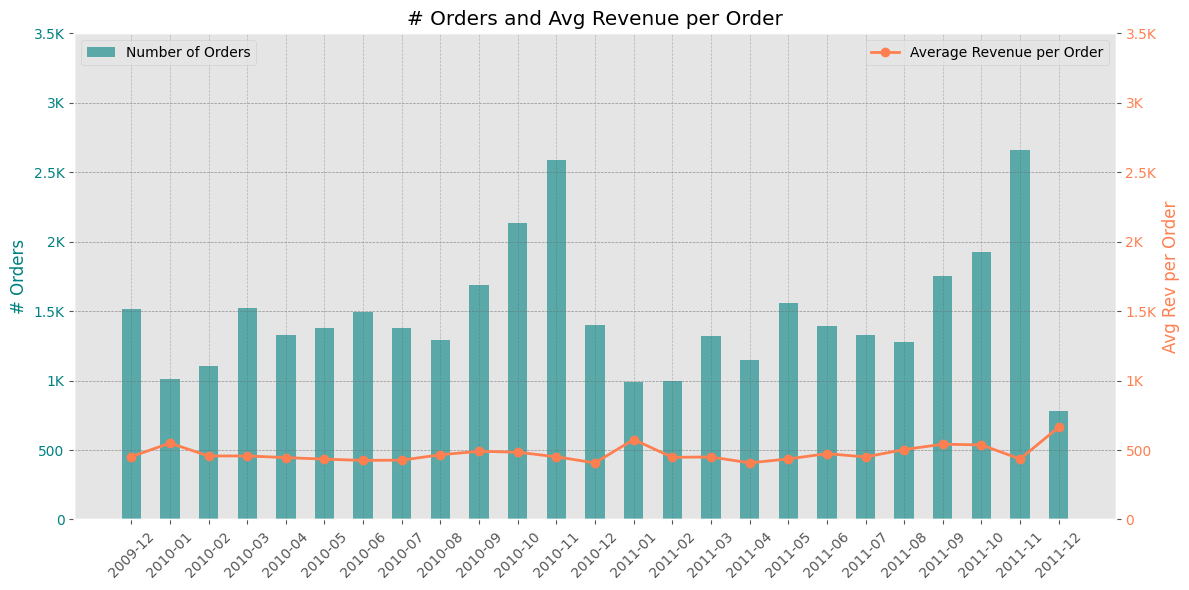

In [12]:
# Setting up the figure and axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Convert DataFrame columns to lists
x_values = avg_rev_per_order["CohortMonth"].tolist()
y_values = avg_rev_per_order["Invoice"].tolist()

# Plot the "Number of Orders" on the primary y-axis with a teal color and thinner bars
ax1.bar(
    x_values,
    y_values,
    color="teal",  # Switched to teal color
    alpha=0.6,
    label="Number of Orders",
    width=0.5,  # Adjust bar width for thinner bars
)
ax1.set_ylabel("# Orders", color="teal")
ax1.tick_params(axis="y", labelcolor="teal")
ax1.set_title("# Orders and Avg Revenue per Order")
ax1.set_xlabel("")  # Remove x-axis label
ax1.legend(loc="upper left")

# Set explicit tick positions for x-axis using FixedLocator
ax1.xaxis.set_major_locator(plt.FixedLocator(range(len(x_values))))
ax1.set_xticklabels(x_values, rotation=45)
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Create the secondary y-axis for the "Average Revenue per Order" with a salmon color
ax2 = ax1.twinx()
ax2.plot(
    x_values,
    avg_rev_per_order["avg_rev_per_order"],
    color="coral",  # Switched to salmon color
    marker="o",
    label="Average Revenue per Order",
    linewidth=2.0,  # Make the line thinner
)
ax2.set_ylabel("Avg Rev per Order", color="coral")
ax2.tick_params(axis="y", labelcolor="coral")
ax2.legend(loc="upper right")

# Set explicit tick positions for x-axis in the secondary axis using FixedLocator
ax2.xaxis.set_major_locator(plt.FixedLocator(range(len(x_values))))
ax2.set_xticklabels(x_values, rotation=45)

# Adjust y-axis limits to range up to 3500
ax1.set_ylim(0, 3500)
ax2.set_ylim(0, 3500)
ax2.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Apply the custom formatter to both y-axes
ax1.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
ax2.yaxis.set_major_formatter(FuncFormatter(custom_formatter))

plt.tight_layout()
plt.show()

### <span style="color:teal;">Analysis</span>

- Overall, there's an evident growth in the number of orders from 2010 to 2011. However, the average revenue for each order remains relatively steady. The close of 2011 witnesses a simultaneous surge in both order volume and average order value.

# <span style="color:teal;">Cohort Analysis:</span>
    
- Retention Rates
- Average Quantity by Cohort

Cohort analysis serves as a valuable descriptive analytics instrument. It classifies customers into distinct cohorts, which are then scrutinized over a period. This analytical approach delivers a richer perspective than typical vanity metrics, enhancing understanding by shedding light on metrics across both the product and customer lifecycle.

There exist three primary cohort classifications:

- **Time Cohorts**: These represent customers who commenced using a product or service within a specific timeframe. Assessing these cohorts provides insights into customer behaviors based on when they initiated with the company's offerings. This timeframe might span daily, monthly, or quarterly.
  
- **Behavior Cohorts**: This cohort involves customers who have made a past product purchase or service subscription. It clusters customers based on the nature of the product or service they've acquired. For instance, those opting for basic services might have distinct requirements compared to those enrolling for premium services. Recognizing the needs of different cohorts enables businesses to tailor products or services to specific segments.
  
- **Size Cohorts**: This classification pertains to the varying customer sizes associated with a company's products or services. Such segmentation might be rooted in the spending amount post-acquisition over a specific duration, or it could be based on a product type where customers predominantly invest. 
  
Given the backdrop, our focus will pivot to the most prevalent cohort analysis type - the time cohorts. Our strategy will be to segment customers into acquisition cohorts founded on the month of their inaugural purchase. Subsequently, we will ascribe a cohort index to each of the customer's purchases, signifying the elapsed months since their first transaction.


In [13]:
retail4 = retail3.copy()
grouping = retail4.groupby('Customer ID')['CohortMonth']
# assign the smalles invoice month value for each customer
retail4['CohortMonth'] = grouping.transform('min')
retail4.tail()

Invoice StockCode                      Description  Quantity  \
1067366  581587     22899     CHILDREN'S APRON DOLLY GIRL          6   
1067367  581587     23254    CHILDRENS CUTLERY DOLLY GIRL          4   
1067368  581587     23255  CHILDRENS CUTLERY CIRCUS PARADE         4   
1067369  581587     22138    BAKING SET 9 PIECE RETROSPOT          3   
1067370  581587      POST                          POSTAGE         1   

                InvoiceDate  Price  Customer ID Country  Monetary  Year  \
1067366 2011-12-09 12:50:00   2.10     12680.00  France     12.60  2011   
1067367 2011-12-09 12:50:00   4.15     12680.00  France     16.60  2011   
1067368 2011-12-09 12:50:00   4.15     12680.00  France     16.60  2011   
1067369 2011-12-09 12:50:00   4.95     12680.00  France     14.85  2011   
1067370 2011-12-09 12:50:00  18.00     12680.00  France     18.00  2011   

         Month CohortMonth  
1067366     12     2011-08  
1067367     12     2011-08  
1067368     12     2011-08  
1067369     12     2011-08  
1067370     12     2011-08

In [14]:
retail4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 779425 entries, 0 to 1067370
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      779425 non-null  object        
 1   StockCode    779425 non-null  object        
 2   Description  779425 non-null  object        
 3   Quantity     779425 non-null  int64         
 4   InvoiceDate  779425 non-null  datetime64[ns]
 5   Price        779425 non-null  float64       
 6   Customer ID  779425 non-null  float64       
 7   Country      779425 non-null  object        
 8   Monetary     779425 non-null  float64       
 9   Year         779425 non-null  int64         
 10  Month        779425 non-null  int64         
 11  CohortMonth  779425 non-null  object        
dtypes: datetime64[ns](1), float64(3), int64(3), object(5)
memory usage: 77.3+ MB


In [15]:
retail4['CohortMonth'] = pd.to_datetime(retail4['CohortMonth'])

def get_month_int (dframe,column):
    year = dframe[column].dt.year
    month = dframe[column].dt.month
    day = dframe[column].dt.day
    return year, month , day 

invoice_year,invoice_month,_ = get_month_int(retail4,'InvoiceDate')
cohort_year,cohort_month,_ = get_month_int(retail4,'CohortMonth')

year_diff = invoice_year - cohort_year 
month_diff = invoice_month - cohort_month 

# convert the total difference to months:
retail4['CohortIndex'] = year_diff * 12 + month_diff + 1 
retail4.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  Monetary  Year  \
0 2009-12-01 07:45:00   6.95     13085.00  United Kingdom     83.40  2009   
1 2009-12-01 07:45:00   6.75     13085.00  United Kingdom     81.00  2009   
2 2009-12-01 07:45:00   6.75     13085.00  United Kingdom     81.00  2009   
3 2009-12-01 07:45:00   2.10     13085.00  United Kingdom    100.80  2009   
4 2009-12-01 07:45:00   1.25     13085.00  United Kingdom     30.00  2009   

   Month CohortMonth  CohortIndex  
0     12  2009-12-01            1  
1     12  2009-12-01            1  
2     12  2009-12-01            1  
3     12  2009-12-01            1  
4     12  2009-12-01            1

In [16]:
# Count the # of monthly active customers in each cohort
grouping = retail4.groupby(['CohortMonth', 'CohortIndex'])
# count the # of customers in each group
cohort_data = grouping['Customer ID'].apply(pd.Series.nunique)
# Return number of unique elements in the object.
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='Customer ID')
cohort_counts

CohortIndex     1      2      3      4      5      6      7      8      9   \
CohortMonth                                                                  
2009-12-01  955.00 337.00 319.00 406.00 363.00 343.00 360.00 327.00 321.00   
2010-01-01  383.00  79.00 119.00 117.00 101.00 115.00  99.00  88.00 107.00   
2010-02-01  374.00  89.00  84.00 109.00  92.00  75.00  72.00 107.00  95.00   
2010-03-01  443.00  84.00 102.00 107.00 103.00  90.00 109.00 134.00 122.00   
2010-04-01  294.00  57.00  57.00  48.00  54.00  66.00  81.00  77.00  31.00   
2010-05-01  254.00  40.00  43.00  44.00  45.00  65.00  54.00  32.00  15.00   
2010-06-01  270.00  47.00  51.00  55.00  62.00  77.00  34.00  24.00  22.00   
2010-07-01  186.00  29.00  34.00  55.00  54.00  26.00  21.00  27.00  27.00   
2010-08-01  162.00  33.00  48.00  52.00  28.00  19.00  16.00  20.00  22.00   
2010-09-01  243.00  55.00  57.00  30.00  22.00  25.00  33.00  24.00  31.00   
2010-10-01  377.00  97.00  55.00  47.00  33.00  31.00  49.00  52.00  40.00   
2010-11-01  325.00  57.00  30.00  31.00  25.00  28.00  42.00  32.00  28.00   
2010-12-01   76.00   7.00   4.00   7.00   9.00   5.00   4.00   7.00   4.00   
2011-01-01   71.00  12.00  15.00  14.00  15.00  11.00  11.00   9.00   8.00   
2011-02-01  124.00  20.00  19.00  23.00  27.00  19.00  19.00  18.00  18.00   
2011-03-01  179.00  33.00  39.00  36.00  40.00  27.00  37.00  36.00  43.00   
2011-04-01  106.00  27.00  21.00  21.00  19.00  25.00  19.00  27.00  12.00   
2011-05-01  111.00  26.00  27.00  18.00  24.00  23.00  29.00  13.00    NaN   
2011-06-01  108.00  25.00  23.00  29.00  22.00  31.00   9.00    NaN    NaN   
2011-07-01  102.00  22.00  31.00  28.00  35.00  16.00    NaN    NaN    NaN   
2011-08-01  106.00  29.00  33.00  28.00  18.00    NaN    NaN    NaN    NaN   
2011-09-01  189.00  51.00  71.00  28.00    NaN    NaN    NaN    NaN    NaN   
2011-10-01  221.00  71.00  35.00    NaN    NaN    NaN    NaN    NaN    NaN   
2011-11-01  191.00  27.00    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-12-01   28.00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

CohortIndex     10     11     12     13     14     15     16     17     18  \
CohortMonth                                                                  
2009-12-01  346.00 403.00 473.00 359.00 270.00 233.00 289.00 251.00 289.00   
2010-01-01  122.00 116.00  66.00  85.00  68.00  72.00  58.00  90.00  76.00   
2010-02-01  103.00  43.00  47.00  57.00  65.00  46.00  75.00  60.00  61.00   
2010-03-01   48.00  51.00  63.00  89.00  72.00  89.00  75.00  77.00  69.00   
2010-04-01   32.00  22.00  41.00  41.00  46.00  46.00  46.00  41.00  44.00   
2010-05-01   21.00  29.00  34.00  39.00  39.00  25.00  32.00  35.00  42.00   
2010-06-01   32.00  29.00  37.00  40.00  33.00  30.00  33.00  36.00  55.00   
2010-07-01   21.00  25.00  27.00  25.00  25.00  36.00  32.00  44.00  15.00   
2010-08-01   21.00  21.00  20.00  25.00  30.00  29.00  32.00  11.00    NaN   
2010-09-01   32.00  28.00  24.00  53.00  40.00  39.00  13.00    NaN    NaN   
2010-10-01   35.00  40.00  49.00  72.00  87.00  26.00    NaN    NaN    NaN   
2010-11-01   29.00  36.00  47.00  83.00  20.00    NaN    NaN    NaN    NaN   
2010-12-01    2.00   7.00  15.00   2.00    NaN    NaN    NaN    NaN    NaN   
2011-01-01   15.00  18.00   8.00    NaN    NaN    NaN    NaN    NaN    NaN   
2011-02-01   22.00   7.00    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-03-01   17.00    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-04-01     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-05-01     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-06-01     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-07-01     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-08-01     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-09-01     NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2011-10-01     NaN   

In [17]:

# * Retention table
# Store the first column as cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]
# divide all values in cohort_counts table by cohort_sizes
# axis=0 to ensure the divide along the row axis 
retention = cohort_counts.divide(cohort_sizes,axis=0) 
retention.index = pd.to_datetime(retention.index).strftime('%Y-%m')
retention.round(3) * 100 # show as % 

CohortIndex     1     2     3     4     5     6     7     8     9     10  \
CohortMonth                                                                
2009-12     100.00 35.30 33.40 42.50 38.00 35.90 37.70 34.20 33.60 36.20   
2010-01     100.00 20.60 31.10 30.50 26.40 30.00 25.80 23.00 27.90 31.90   
2010-02     100.00 23.80 22.50 29.10 24.60 20.10 19.30 28.60 25.40 27.50   
2010-03     100.00 19.00 23.00 24.20 23.30 20.30 24.60 30.20 27.50 10.80   
2010-04     100.00 19.40 19.40 16.30 18.40 22.40 27.60 26.20 10.50 10.90   
2010-05     100.00 15.70 16.90 17.30 17.70 25.60 21.30 12.60  5.90  8.30   
2010-06     100.00 17.40 18.90 20.40 23.00 28.50 12.60  8.90  8.10 11.90   
2010-07     100.00 15.60 18.30 29.60 29.00 14.00 11.30 14.50 14.50 11.30   
2010-08     100.00 20.40 29.60 32.10 17.30 11.70  9.90 12.30 13.60 13.00   
2010-09     100.00 22.60 23.50 12.30  9.10 10.30 13.60  9.90 12.80 13.20   
2010-10     100.00 25.70 14.60 12.50  8.80  8.20 13.00 13.80 10.60  9.30   
2010-11     100.00 17.50  9.20  9.50  7.70  8.60 12.90  9.80  8.60  8.90   
2010-12     100.00  9.20  5.30  9.20 11.80  6.60  5.30  9.20  5.30  2.60   
2011-01     100.00 16.90 21.10 19.70 21.10 15.50 15.50 12.70 11.30 21.10   
2011-02     100.00 16.10 15.30 18.50 21.80 15.30 15.30 14.50 14.50 17.70   
2011-03     100.00 18.40 21.80 20.10 22.30 15.10 20.70 20.10 24.00  9.50   
2011-04     100.00 25.50 19.80 19.80 17.90 23.60 17.90 25.50 11.30   NaN   
2011-05     100.00 23.40 24.30 16.20 21.60 20.70 26.10 11.70   NaN   NaN   
2011-06     100.00 23.10 21.30 26.90 20.40 28.70  8.30   NaN   NaN   NaN   
2011-07     100.00 21.60 30.40 27.50 34.30 15.70   NaN   NaN   NaN   NaN   
2011-08     100.00 27.40 31.10 26.40 17.00   NaN   NaN   NaN   NaN   NaN   
2011-09     100.00 27.00 37.60 14.80   NaN   NaN   NaN   NaN   NaN   NaN   
2011-10     100.00 32.10 15.80   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-11     100.00 14.10   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-12     100.00   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

CohortIndex    11    12    13    14    15    16    17    18    19    20    21  \
CohortMonth                                                                     
2009-12     42.20 49.50 37.60 28.30 24.40 30.30 26.30 30.30 28.30 26.00 25.50   
2010-01     30.30 17.20 22.20 17.80 18.80 15.10 23.50 19.80 18.50 19.60 24.30   
2010-02     11.50 12.60 15.20 17.40 12.30 20.10 16.00 16.30 14.40 23.00 23.00   
2010-03     11.50 14.20 20.10 16.30 20.10 16.90 17.40 15.60 17.60 20.10 21.20   
2010-04      7.50 13.90 13.90 15.60 15.60 15.60 13.90 15.00 18.00 22.40  5.80   
2010-05     11.40 13.40 15.40 15.40  9.80 12.60 13.80 16.50 15.40  4.70   NaN   
2010-06     10.70 13.70 14.80 12.20 11.10 12.20 13.30 20.40  5.20   NaN   NaN   
2010-07     13.40 14.50 13.40 13.40 19.40 17.20 23.70  8.10   NaN   NaN   NaN   
2010-08     13.00 12.30 15.40 18.50 17.90 19.80  6.80   NaN   NaN   NaN   NaN   
2010-09     11.50  9.90 21.80 16.50 16.00  5.30   NaN   NaN   NaN   NaN   NaN   
2010-10     10.60 13.00 19.10 23.10  6.90   NaN   NaN   NaN   NaN   NaN   NaN   
2010-11     11.10 14.50 25.50  6.20   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2010-12      9.20 19.70  2.60   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-01     25.40 11.30   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-02      5.60   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-03       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-04       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-05       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-06       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-07       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-08       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2011-09       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
201

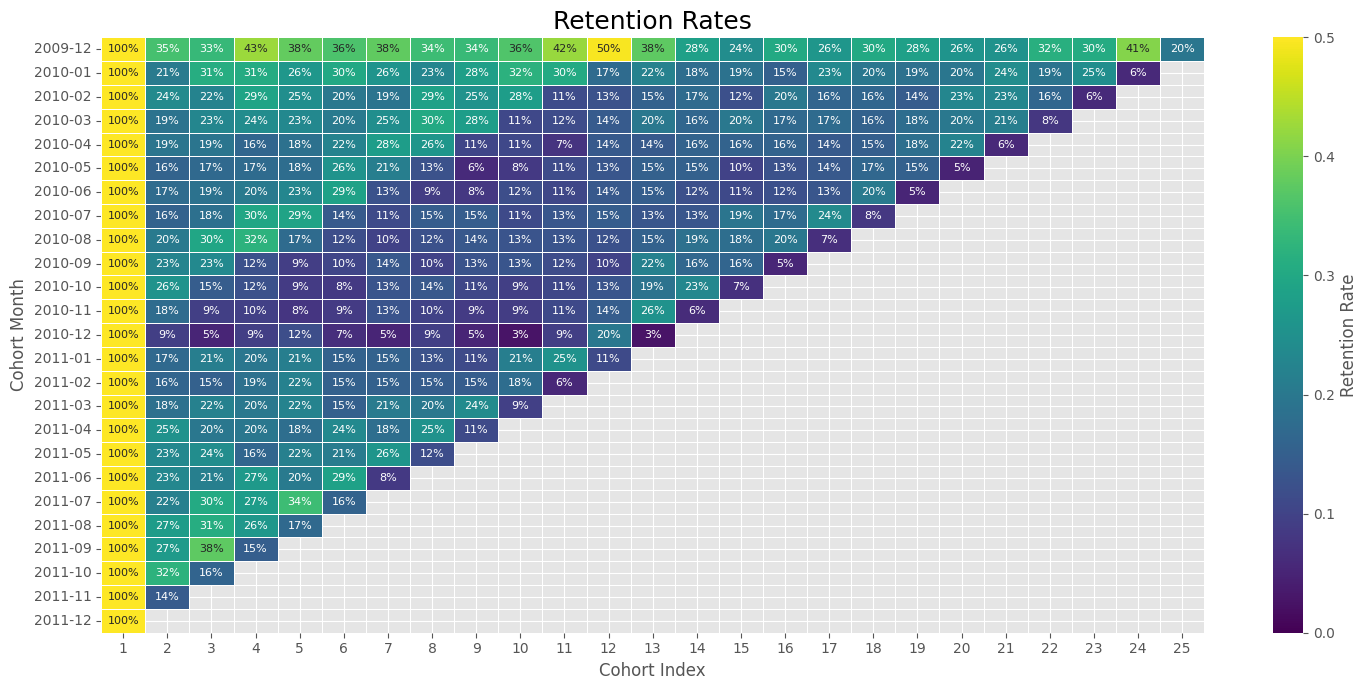

In [18]:
# Retention % Heatmap
plt.figure(figsize=(15, 7)) 
plt.title('Retention Rates', fontsize=18)

sns.heatmap(
    data=retention,
    annot=True,
    fmt='.0%',
    vmin=0.0,
    vmax=0.5,
    cmap="viridis",  
    cbar_kws={'label': 'Retention Rate'},  
    linewidths=0.5,  
    linecolor='white',  
    annot_kws={"fontsize": 8}  
)

plt.ylabel('Cohort Month')  
plt.xlabel('Cohort Index') 
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.tight_layout()  
plt.show()

### <span style="color:teal;">Analysis:</span>

- **Initial Retention**: Every cohort commences with a 100% retention rate, which is the anticipated trajectory.
  
- **Retention Decline**: A distinct reduction in retention materializes as we traverse rightwards through the CohortIndex. This trend is frequently witnessed in numerous user-based metrics, wherein initial involvement tends to be higher.
  
- **Variability in Retention**: Despite a general trend of diminishing retention rates over time for each cohort, the rate of decline isn't uniform. Specific cohorts, such as 2010-02 and 2010-03, showcase superior retention relative to cohorts like 2010-08 in the ensuing months.
  
- **Highest Retention Points**: The more pronounced shades in the matrix (for instance, the 50% in the 2009-12 cohort) pinpoint months that register the peak retention rates post the inaugural month. A striking observation is the escalating trajectory of this particular cohort towards the end of the year. A deeper dive into congruencies among cohort purchases or favored items and subsequent A/B testing could unearth potential opportunities to harness.
  
- **Consistent Engagement**: Remarkably, numerous cohorts, even after an extended duration, report retention rates surpassing 20%. This underscores a user segment that maintains a steadfast engagement with the service or platform.


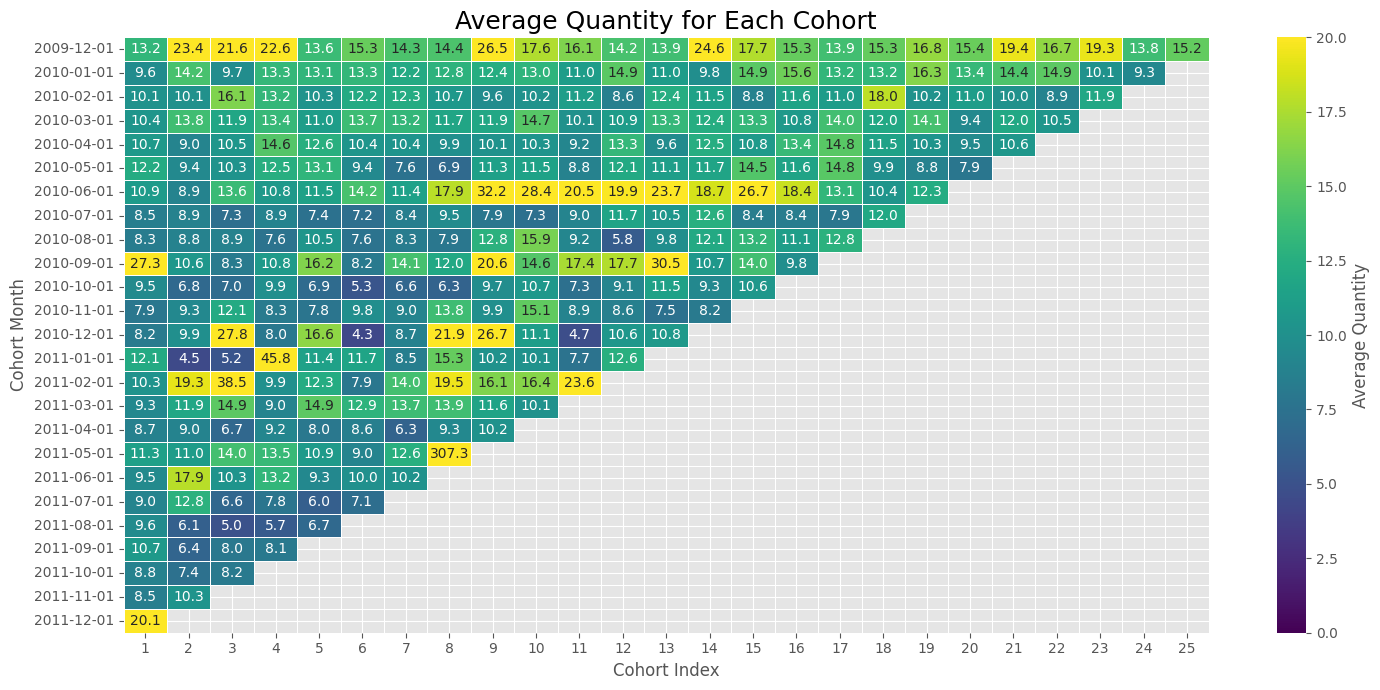

In [19]:
# Average quantity for each cohort
grouping = retail4.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['Quantity'].mean()
cohort_data = cohort_data.reset_index()
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')
average_quantity.round(1)
average_quantity.index = average_quantity.index.date

# heatmap
plt.figure(figsize=(15, 7))  
plt.title('Average Quantity for Each Cohort', fontsize=18)
sns.heatmap(data=average_quantity, 
            annot=True, 
            fmt=".1f", # round 1 decimal place
            vmin=0.0, 
            vmax=20, 
            cmap="viridis",
            cbar_kws={'label': 'Average Quantity'},  
            linewidths=0.5,  
            linecolor='white',  
            annot_kws={"fontsize": 10})  

plt.ylabel('Cohort Month')  
plt.xlabel('Cohort Index') 
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.tight_layout()  
plt.show()

### <span style="color:teal;">Analysis:</span>

1. **Retention Pattern**: 
   - Predominantly, the earlier cohorts, such as those initiated in December 2009, seem to register higher average quantities as we progress along their subsequent months (denoted by `Cohort Index`). This retention appears more pronounced than the patterns observed in later cohorts.

2. **Notable Peaks**: 
   - A remarkable surge is evident in the cohort from June 2010, specifically around its 6th and 7th months.
   - **Purchasing versus Staying Engaged**: A declining retention rate doesn't innately signify reduced purchases. The metric "Average Quantity for Each Cohort" conveys that, often, even with a diminishing cohort size, the mean quantity remains relatively stable. This could be indicative of the retained customers' loyalty or heightened engagement, often leading them to purchase in quantities that are either on par or exceed previous levels.
       - Case in point: The cohort from May 2011 displays an anomaly during its 7th month, wherein the mean quantity ascends sharply to 307.3, significantly surpassing other recorded values. In an intriguing contrast, the Retention correlation plot reveals a somewhat inverse trend, given that the retention rates have been on a decline. Such instances beckon further analysis, potentially providing actionable insights for marketing campaigns or experiments.

3. **General Trend**: 
   - Progressing rightwards (with an increasing `Cohort Index`), we observe a consistent decline in the average quantities across most cohorts. This decline resonates with conventional user behaviors, where, over prolonged engagements, users tend to exhibit diminished purchasing patterns on average.

4. **Data Density**: 
   - The initial months (or the leftmost side of the heatmap) are data-dense.
   - However, as we traverse to the right, the data thins out, which is coherent with the notion that the recent cohorts haven't spanned a duration long enough to yield substantial data for their subsequent months.

---

## <span style="color:teal;"> RFM Segmentation Summary</span>

RFM Segmentation categorizes customers based on their transaction history:

1. **Recency (R):** Days since the last purchase.
2. **Frequency (F):** Total number of purchases.
3. **Monetary (M):** Total money spent.

### <span style="color:teal;"> Implementation Steps:</span>

#### 1. Compute RFM Metrics:

- Calculate the days between a customer's last purchase and the reference date (10th December 2011).
- Count purchases for each customer.
- Sum the total spending for each customer.

#### 2. Assign Scores:

- Rank customers based on each metric. Higher scores are given to more recent purchases, more frequent purchases, and higher spending.

#### 3. Create RFM Segments:

- Combine individual RFM scores to segment customers.


In [20]:
retail4.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  Monetary  Year  \
0 2009-12-01 07:45:00   6.95     13085.00  United Kingdom     83.40  2009   
1 2009-12-01 07:45:00   6.75     13085.00  United Kingdom     81.00  2009   
2 2009-12-01 07:45:00   6.75     13085.00  United Kingdom     81.00  2009   
3 2009-12-01 07:45:00   2.10     13085.00  United Kingdom    100.80  2009   
4 2009-12-01 07:45:00   1.25     13085.00  United Kingdom     30.00  2009   

   Month CohortMonth  CohortIndex  
0     12  2009-12-01            1  
1     12  2009-12-01            1  
2     12  2009-12-01            1  
3     12  2009-12-01            1  
4     12  2009-12-01            1

In [21]:
def compute_rfm(dataframe):
    """
    Compute the Recency, Frequency, and Monetary (RFM) values for each customer.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe containing transaction data with required columns:
        * 'InvoiceDate': Date of the transaction
        * 'Invoice': Unique identifier for each transaction
        * 'Total Sale': Total sale amount for each transaction
        * 'Customer ID': Unique identifier for each customer

    Returns:
    - rfm_df (pd.DataFrame): A dataframe with RFM values for each customer, columns include:
        * 'Customer ID': Unique identifier for each customer
        * 'Recency': Days since the customer's last transaction
        * 'Frequency': Number of transactions by the customer
        * 'Monetary': Total sale amount across all of the customer's transactions
    """
    
    # Compute Monetary value for each customer
    monetary = dataframe.groupby('Customer ID')['Monetary'].sum().reset_index()

    # Compute Frequency for each customer
    frequency = dataframe.groupby('Customer ID')['Invoice'].count().reset_index()
    frequency.columns = ['Customer ID', 'Frequency']

    # Merge monetary and frequency dataframes
    rfm_df = pd.merge(monetary, frequency, on='Customer ID', how='inner')

    # Calculate Recency for each customer
    max_transaction_date = max(dataframe['InvoiceDate'])
    dataframe['Time Since Purchase'] = max_transaction_date - dataframe['InvoiceDate']
    recency = dataframe.groupby('Customer ID')['Time Since Purchase'].min().reset_index()
    recency['Time Since Purchase'] = recency['Time Since Purchase'].dt.days

    # Merge rfm_df with recency dataframe
    rfm_df = pd.merge(rfm_df, recency, on='Customer ID', how='inner')
    rfm_df.columns = ['Customer ID', 'Monetary', 'Frequency', 'Recency']

    return rfm_df


rfm_df = compute_rfm(retail4)
print(rfm_df.head())
print(rfm_df.shape)

   Customer ID  Monetary  Frequency  Recency
0     12346.00  77556.46         34      325
1     12347.00   4921.53        222        1
2     12348.00   2019.40         51       74
3     12349.00   4428.69        175       18
4     12350.00    334.40         17      309
(5878, 4)


## <span style="color:teal;">Scoring for RFM Segmentation</span>

RFM segmentation leverages ranks from 1 to 5 for each of the three metrics, with the interpretations as follows:

### <span style="color:teal;">Recency (R) Score:</span>
- **1:** Most recent purchase.
- **5:** Least recent purchase.
  
**Note**: A lower recency score indicates a more recent customer, which is desirable.

### <span style="color:teal;">Frequency (F) Score:</span>
- **5:** Most frequent purchases.
- **1:** Least frequent purchases.

**Note**: A higher frequency score indicates a customer who makes purchases more often, which is desirable.

### <span style="color:teal;">Monetary (M) Score:</span>
- **5:** Highest spending.
- **1:** Lowest spending.

**Note**: A higher monetary score indicates a customer who spends more, which is preferable.


In [22]:
# Create the recency_score, frequency_score, and monetary_score values.
rfm_df["Recency_Score"] = pd.qcut(rfm_df["Recency"], 5, labels = [5, 4, 3, 2, 1]) 
rfm_df["Frequency_Score"] = pd.qcut(rfm_df["Frequency"].rank(method = "first"), 5, labels = [1, 2, 3, 4, 5])
rfm_df["Monetary_Score"] = pd.qcut(rfm_df["Monetary"], 5, labels = [1, 2, 3, 4, 5])
rfm_df['RFM_Score'] = rfm_df[['Recency_Score','Frequency_Score','Monetary_Score']].sum(axis=1) 
rfm_df["RFM_Segment"] = rfm_df["Recency_Score"].astype(str) + rfm_df["Frequency_Score"].astype(str) + rfm_df["Monetary_Score"].astype(str)
rfm_df.head(10)

Customer ID  Monetary  Frequency  Recency Recency_Score Frequency_Score  \
0     12346.00  77556.46         34      325             2               2   
1     12347.00   4921.53        222        1             5               5   
2     12348.00   2019.40         51       74             3               3   
3     12349.00   4428.69        175       18             5               5   
4     12350.00    334.40         17      309             2               2   
5     12351.00    300.93         21      374             2               2   
6     12352.00   2849.84        103       35             4               4   
7     12353.00    406.76         24      203             2               2   
8     12354.00   1079.40         58      231             2               3   
9     12355.00    947.61         35      213             2               2   

  Monetary_Score  RFM_Score RFM_Segment  
0              5          9         225  
1              5         15         555  
2              4         10         334  
3              5         15         555  
4              2          6         222  
5              2          6         222  
6              4         12         444  
7              2          6         222  
8              3          8         233  
9              3          7         223

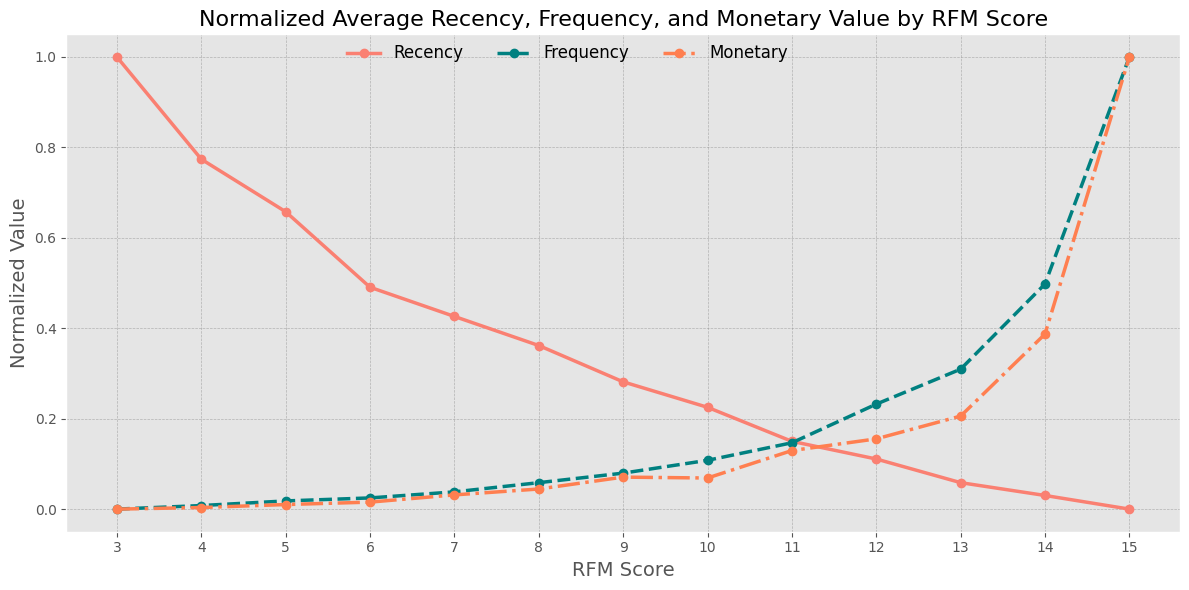

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

rfm_agg = rfm_df.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

# Scale the metrics between 0 and 1
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(rfm_agg[['Recency', 'Frequency', 'Monetary']])
rfm_scaled = pd.DataFrame(scaled_values, columns=['Recency', 'Frequency', 'Monetary'])
rfm_scaled['RFM_Score'] = rfm_agg['RFM_Score']
rfm_stacked = rfm_scaled.set_index('RFM_Score')
colors = ["salmon", "teal", "coral"]

fig, ax = plt.subplots(figsize=(12, 6))
line_styles = ['-', '--', '-.']

for column, line_style, color in zip(rfm_stacked.columns, line_styles, colors):
    rfm_stacked[column].plot(
        kind='line',
        ax=ax,
        linestyle=line_style,
        color=color,
        linewidth=2.5,
        marker='o'  
    )

ax.set_title("Normalized Average Recency, Frequency, and Monetary Value by RFM Score", fontsize=16)
ax.set_ylabel("Normalized Value", fontsize=14)
ax.set_xlabel("RFM Score", fontsize=14)
ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)  
legend = ax.legend(loc='upper center', bbox_to_anchor=(0.45, 1.01), ncol=3, fontsize=12, frameon=False)
legend.set_title(None)  

# Setting x-axis ticks to show all whole numbers from 3 to 15
ax.set_xticks(range(3, 16))
plt.tight_layout()
plt.show()

In [24]:
# Segment Scores
# Credit: https://documentation.bloomreach.com/engagement/docs/rfm-segmentation

segment_scores = {
    "champions": [555, 554, 544, 545, 454, 455, 445],
    "loyal": [543, 444, 435, 355, 354, 345, 344, 335],
    "potential_loyalists": [
        553, 551, 552, 541, 542, 533, 532, 531, 
        452, 451, 442, 441, 431, 453, 433, 432, 
        423, 353, 352, 351, 342, 341, 333, 323
    ],
    "new_customers": [512, 511, 422, 421, 412, 411, 311],
    "promising": [
        525, 524, 523, 522, 521, 515, 514, 513, 
        425, 424, 413, 414, 415, 315, 314, 313
    ],
    "need_attention": [535, 534, 443, 434, 343, 334, 325, 324],
    "about_to_sleep": [331, 321, 312, 221, 213, 231, 241, 251],
    "cannot_lose_them_but_losing": [155, 154, 144, 214, 215, 115, 114, 113],
    "at_risk": [
        255, 254, 245, 244, 253, 252, 243, 242, 
        235, 234, 225, 224, 153, 152, 145, 143, 
        142, 135, 134, 133, 125, 124
    ],
    "hibernating_customers": [
        332, 322, 233, 232, 223, 222, 132, 123, 
        122, 212, 211
    ],
    "losing_but_maybe_engaged": [111, 112, 121, 131, 141, 151]
}

# Reverse the dictionary
reverse_segment_scores = {
    score: segment 
    for segment, scores in segment_scores.items() 
    for score in scores
}

# Create the new 'segments' column
rfm_df['segment'] = rfm_df['RFM_Segment'].astype(int).map(reverse_segment_scores)
rfm_df.head(10)

Customer ID  Monetary  Frequency  Recency Recency_Score Frequency_Score  \
0     12346.00  77556.46         34      325             2               2   
1     12347.00   4921.53        222        1             5               5   
2     12348.00   2019.40         51       74             3               3   
3     12349.00   4428.69        175       18             5               5   
4     12350.00    334.40         17      309             2               2   
5     12351.00    300.93         21      374             2               2   
6     12352.00   2849.84        103       35             4               4   
7     12353.00    406.76         24      203             2               2   
8     12354.00   1079.40         58      231             2               3   
9     12355.00    947.61         35      213             2               2   

  Monetary_Score  RFM_Score RFM_Segment                segment  
0              5          9         225                at_risk  
1              5         15         555              champions  
2              4         10         334         need_attention  
3              5         15         555              champions  
4              2          6         222  hibernating_customers  
5              2          6         222  hibernating_customers  
6              4         12         444                  loyal  
7              2          6         222  hibernating_customers  
8              3          8         233  hibernating_customers  
9              3          7         223  hibernating_customers

In [25]:
# Create a dictionary with 'Customer ID' as the key and 'segment' as the value
customer_segment_dict = rfm_df['segment'].to_dict()
print(customer_segment_dict)

{0: 'at_risk', 1: 'champions', 2: 'need_attention', 3: 'champions', 4: 'hibernating_customers', 5: 'hibernating_customers', 6: 'loyal', 7: 'hibernating_customers', 8: 'hibernating_customers', 9: 'hibernating_customers', 10: 'champions', 11: 'champions', 12: 'champions', 13: 'champions', 14: 'champions', 15: 'hibernating_customers', 16: 'champions', 17: 'hibernating_customers', 18: 'champions', 19: 'hibernating_customers', 20: 'losing_but_maybe_engaged', 21: 'new_customers', 22: 'hibernating_customers', 23: 'cannot_lose_them_but_losing', 24: 'champions', 25: 'champions', 26: 'need_attention', 27: 'hibernating_customers', 28: 'champions', 29: 'promising', 30: 'hibernating_customers', 31: 'at_risk', 32: 'loyal', 33: 'loyal', 34: 'champions', 35: 'champions', 36: 'loyal', 37: 'new_customers', 38: 'at_risk', 39: 'hibernating_customers', 40: 'losing_but_maybe_engaged', 41: 'champions', 42: 'at_risk', 43: 'hibernating_customers', 44: 'champions', 45: 'losing_but_maybe_engaged', 46: 'loyal', 4

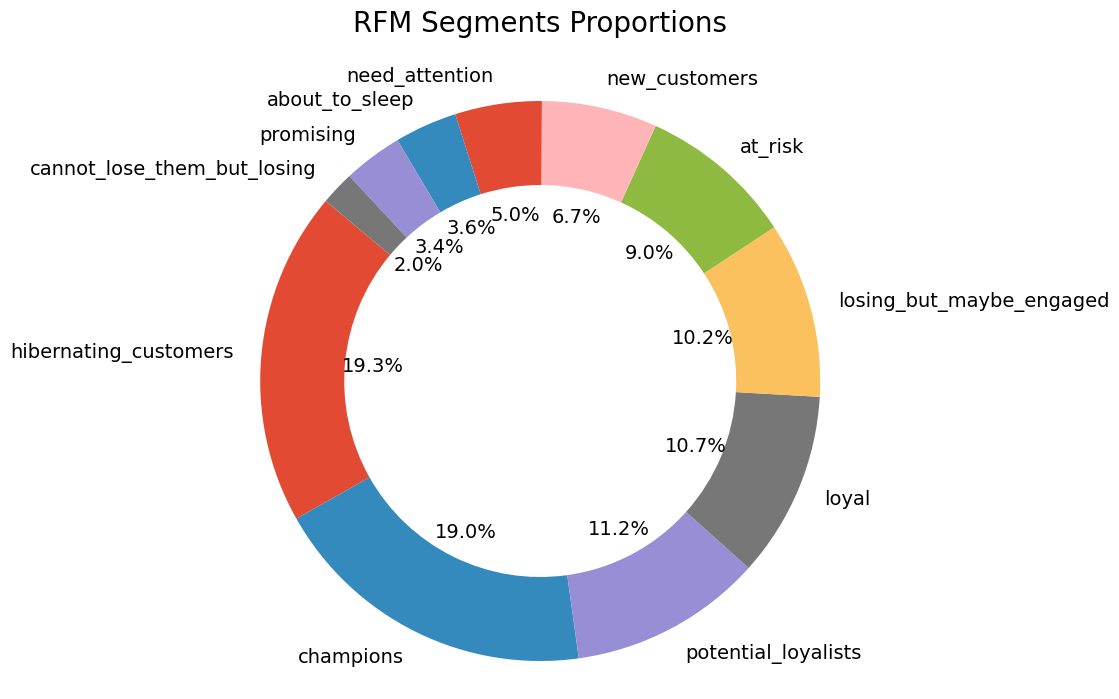

In [26]:
plt.style.use("ggplot")

# Donut Chart
segment_counts = rfm_df['segment'].value_counts()
plt.figure(figsize=(12,8))
plt.pie(segment_counts, labels=segment_counts.index, autopct=lambda p:f'{p:.1f}%', 
        startangle=140, wedgeprops=dict(width=0.3), textprops={'fontsize': 14})

plt.title('RFM Segments Proportions', fontsize=20, pad=30)
plt.gca().set_facecolor('white')
plt.gca().axis("equal")

# Remove axis
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.gca().spines["bottom"].set_visible(False)
plt.gca().spines["left"].set_visible(False)
plt.show()

In [27]:
rfm_df[["segment", "Recency", "Frequency", "Monetary"]].groupby("segment").agg(["mean", "sum", "count"])

Recency               Frequency                \
                               mean     sum count      mean     sum count   
segment                                                                     
about_to_sleep               230.73   48915   212     24.74    5244   212   
at_risk                      373.64  197284   528    117.18   61872   528   
cannot_lose_them_but_losing  473.40   54441   115    105.46   12128   115   
champions                     16.66   18628  1118    424.12  474162  1118   
hibernating_customers        341.56  387330  1134     27.93   31677  1134   
losing_but_maybe_engaged     568.22  339225   597     14.12    8430   597   
loyal                         77.22   48725   631    171.54  108243   631   
need_attention                61.13   17973   294     74.03   21766   294   
new_customers                 55.33   21690   392     13.32    5220   392   
potential_loyalists           55.69   36533   656     70.94   46536   656   
promising                     33.87    6807   201     20.63    4147   201   

                            Monetary                    
                                mean         sum count  
segment                                                 
about_to_sleep                300.37    63677.63   212  
at_risk                      2439.21  1287904.65   528  
cannot_lose_them_but_losing  2996.81   344633.59   115  
champions                   10166.66 11366330.05  1118  
hibernating_customers         466.30   528783.52  1134  
losing_but_maybe_engaged      184.04   109873.84   597  
loyal                        3209.47  2025178.49   631  
need_attention               1863.96   548004.30   294  
new_customers                 237.44    93077.11   392  
potential_loyalists           781.68   512780.81   656  
promising                    2460.50   494560.27   201

# <span style="color:teal;">RFM<span style="color:teal;"><b>T</b></span> Segmentation</span>

<span style="color:salmon;">**Caveat:**</span>  this is a bonus section that needs tuning. I got carried away into the analysis and kept finding interesting approaches and decided to add this additional component. Credit to yellowbrick creators and contributers.

In addition to the traditional RFM segmentation, we are introducing a time-based component, **T**, representing a customer's age in weeks.

## <span style="color:teal;">Components:</span>

- **R**: Recency - Time since the last purchase.
- **F**: Frequency - Number of transactions.
- **M**: Monetary - Total money spent.
- **T**: Time - Age of customer in terms of weeks since the first purchase.

## <span style="color:teal;">Objective:</span>

We aim to employ the **BG/NBD Model** (Beta-Geometric/Negative Binomial Distribution model) to predict:

1. Customer churn probability.
2. Customer lifetime value.

### <span style="color:teal;">About BG/NBD Model (BetaGeoFitter):</span>

This model is a mainstay in customer analytics. Here's what it assumes:

1. The number of transactions made by a customer follows a **Poisson distribution** with transaction rate λ.
2. The probability that a customer drops out after each transaction is p and adheres to a **geometric distribution**.

**Benefit**: By integrating the BG/NBD model with RFM<span style="color:teal;"><b>T</b></span> segmentation, we can enhance our ability to predict future customer behavior and subsequently tailor marketing strategies more effectively.


In [28]:
retail2.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  Monetary  
0 2009-12-01 07:45:00   6.95     13085.00  United Kingdom     83.40  
1 2009-12-01 07:45:00   6.75     13085.00  United Kingdom     81.00  
2 2009-12-01 07:45:00   6.75     13085.00  United Kingdom     81.00  
3 2009-12-01 07:45:00   2.10     13085.00  United Kingdom    100.80  
4 2009-12-01 07:45:00   1.25     13085.00  United Kingdom     30.00

In [29]:
snapshot_date = retail2['InvoiceDate'].max() + dt.timedelta(days=1)

rfmt_df = retail2.groupby("Customer ID").agg({"InvoiceDate" : [lambda InvoiceDate: (InvoiceDate.max() - InvoiceDate.min()).days, # R
                                        lambda InvoiceDate: (snapshot_date - InvoiceDate.min()).days], # T
                                         "Invoice" : lambda Invoice: Invoice.nunique(), # F
                                         "Monetary": lambda Monetary: Monetary.sum()}) # M

rfmt_df.columns = rfmt_df.columns.droplevel(0)
rfmt_df.columns = ["R", "T", "F", "M"]
rfmt_df = rfmt_df[["R", "F", "M", "T"]]
rfmt_df = rfmt_df[rfmt_df["F"] > 1]
rfmt_df["M"] = rfmt_df["M"] / rfmt_df["F"] #avg monetary
rfmt_df["T"] = rfmt_df["T"] / 7
rfmt_df["R"] = rfmt_df["R"] / 7
print(rfmt_df.head())
print(rfmt_df.shape)

                R   F       M      T
Customer ID                         
12346.00    57.14  12 6463.04 103.71
12347.00    57.43   8  615.19  57.71
12348.00    51.71   5  403.88  62.57
12349.00    81.43   4 1107.17  84.14
12352.00    50.86  10  284.98  56.14
(4255, 4)


In [30]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef = 0.01)
bgf.fit(rfmt_df["F"], rfmt_df["R"], rfmt_df["T"])
print(bgf)
bgf.summary

<lifetimes.BetaGeoFitter: fitted with 4255 subjects, a: 0.14, alpha: 9.84, b: 1.49, r: 1.51>


coef  se(coef)  lower 95% bound  upper 95% bound
r      1.51      0.04             1.44             1.58
alpha  9.84      0.29             9.27            10.42
a      0.14      0.01             0.13             0.16
b      1.49      0.06             1.36             1.61

# <span style="color:teal;">Forecasting Customer Transactions</span>

The adopted model furnishes us with the capability to forecast the anticipated transaction frequency for individual customers in the ensuing 3 and 6 months.

### <span style="color:teal;">Model Insight:</span>
Taking a specific customer as a case in point: customer #14911.00 is projected to initiate approximately 27 transactions in the forthcoming 2 months. 

**Implications**: Such predictive capabilities can serve as a cornerstone for strategic marketing interventions. Equipped with the knowledge of when customers are most likely to transact, marketing teams can design timely and targeted campaigns to maximize customer engagement.

## <span style="color:teal;">Stratifying Customers: A Hierarchical View</span>

A consequential capability of these models is the ability to stratify customers based on their projected transactional frequency. By ranking customers from the most to the least likely to transact in the upcoming period, businesses can prioritize their marketing efforts, ensuring they resonate with the most promising segments of their customer base.


In [31]:

# * 2 months preds:
t = 8
rfmt_df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, rfmt_df['F'], rfmt_df['R'], rfmt_df['T'])
rfmt_df.sort_values(by='predicted_purchases', ascending = False).head(20)

R    F       M      T  predicted_purchases
Customer ID                                                
14911.00    105.29  398  732.21 105.57                27.53
12748.00    104.86  336  159.34 105.00                23.38
17841.00    105.00  211  324.86 105.29                14.68
15311.00    105.43  208  552.72 105.57                14.44
13089.00    104.86  203  558.70 105.29                14.12
14606.00    105.00  192  156.00 105.29                13.37
14156.00    104.00  156 2009.22 105.57                10.78
14646.00    105.00  151 3500.68 105.29                10.53
18102.00    105.43  145 4006.81 105.57                10.09
13694.00    104.43  143 1368.12 105.00                10.00
15061.00    104.86  127  995.19 105.57                 8.84
14527.00    105.00  122  223.34 105.43                 8.51
17949.00    105.14  118  994.19 105.43                 8.24
12971.00    102.86  116  135.38 103.43                 8.24
16422.00     97.00  109  568.08  99.57                 7.90
13798.00    104.14  110  685.72 104.43                 7.76
13408.00    104.71  106  473.35 105.14                 7.43
17961.00    102.43  100   28.67 105.43                 6.87
15039.00    102.71   93  420.88 104.29                 6.56
16013.00    104.00   84  667.60 104.57                 5.93

# <span style="color:teal;">Frequency/Recency Matrix Visualization</span>

Understanding the health and potential future interactions of a customer segment is essential. The Frequency/Recency matrix provides a robust visualization to discern the expected transactional behavior of customers based on two pivotal metrics: **Frequency** and **Recency**.

## <span style="color:teal;">Decoding the Matrix:</span>

- **Scenario**: Imagine a customer who has been actively purchasing every day for three consecutive weeks but has gone silent for several months. The likelihood of this customer being still engaged or "alive" is diminutive.

- **Contrast**: Another customer, who has a pattern of buying once every quarter and made a purchase the previous quarter, has a high probability of still being an active customer.

The matrix delineates the expected number of transactions a hypothetical customer might make in a forthcoming period based on:
1. **Recency (R)**: Age of the customer's last purchase.
2. **Frequency (F)**: Count of repeat transactions the customer has made.

By leveraging this matrix, businesses can anticipate transactional behaviors, segment customers aptly, and implement strategies tailored to each segment's unique characteristics.

*Reference*: [Lifetimes Documentation](https://lifetimes.readthedocs.io/)



C:\Users\Kunal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lifetimes\fitters\beta_geo_fitter.py:256: RuntimeWarning: overflow encountered in scalar power
  denominator = 1 + (x > 0) * (a / (b + x - 1)) * ((alpha + T) / (alpha + recency)) ** (r + x)


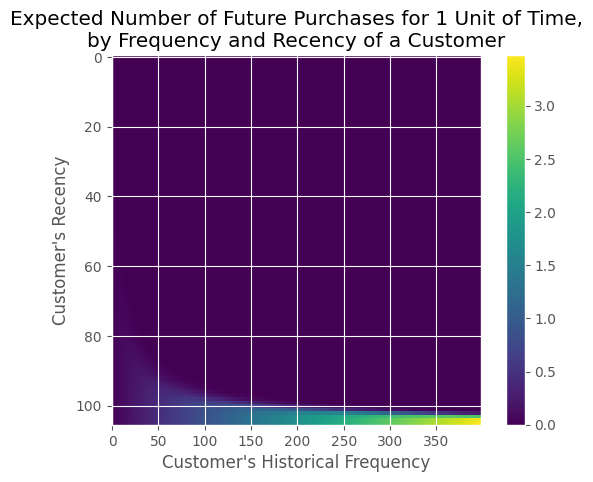

In [32]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf);

# <span style="color:teal;">Interpreting the Frequency/Recency Matrix</span>

The Frequency/Recency matrix is a pivotal tool in understanding customer behavior. Here's a breakdown of our observations:

## <span style="color:teal;">Key Insights:</span>

1. **Top Customers**:
    - Customers positioned in the bottom right, those who have made over 250-300 purchases and whose most recent purchase occurred around their 25th week as a customer, are our top performers. They display consistent and high-frequency purchasing behavior.
   
2. **Cold Customers**:
    - The darker areas represent customers who began with a high purchasing rate but have since become dormant. The absence of recent transactions makes these customers a concern.

3. **"Touch-and-Go" Customers**:
    - There's an interesting fading tail observed around the (50,90) mark. These customers make infrequent purchases but maintain an occasional engagement. While they might not be the highest value customers, they still hold potential for future transactions.
    - **Strategy**: The marketing team can allocate a smaller budget for touchpoints with these customers, focusing on subtle brand awareness campaigns to keep them engaged and possibly nudge them toward another purchase.

## <span style="color:teal;">Probability of Being "Alive":</span>
Another crucial matrix to consider is the probability of a customer still being "alive" or active. This matrix will allow us to discern which customers are likely to make future transactions, enabling more targeted and effective marketing strategies.



<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

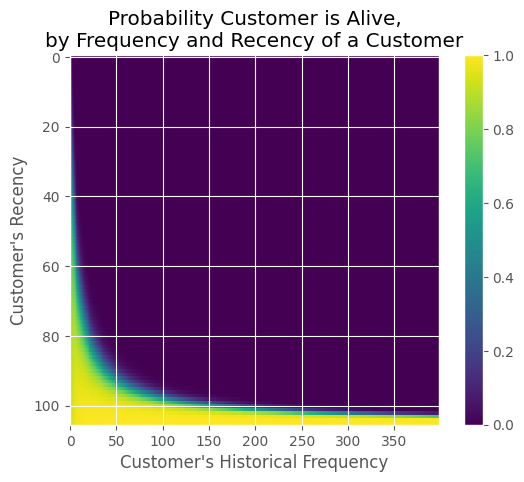

In [33]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

# <span style="color:teal;">Understanding the "Alive" Probability Matrix</span>

The matrix reflecting the probability of a customer being "alive" mirrors patterns observed in our previous retention heatmap. This matrix provides further insights into customer attrition and potential purchasing behaviors based on their recency and frequency.

## <span style="color:teal;">Observations:</span>

1. **High Recency, Low Frequency**:
    - Located in the bottom-left.
    - Represents customers who have recently initiated their purchasing journey with us.
    - Their "alive" probability is naturally high, given the recency of their initial transaction.
    
2. **High Frequency, Low Recency**:
    - Positioned towards the right but still close to the bottom.
    - These are customers who had frequent transactions in the past but have become less active recently.
    - As frequency climbs but recency lags, their probability of being "alive" decreases. This could indicate potential churn.

3. **High Recency, High Frequency**:
    - This hypothetical section in the top-right corner would be filled with our star customers.
    - They frequently transact and have done so recently.
    - Their "alive" probability would be at a peak, indicating consistent engagement.

4. **Low Frequency, High Recency**:
    - Located in the top-left.
    - These customers made sporadic purchases and have not been active for a while.
    - Their probability of being "alive" or returning for future transactions is relatively low.

## <span style="color:teal;">Conclusion:</span>
This matrix offers a clearer understanding of customer lifecycles. By identifying where customers sit within this matrix, businesses can tailor marketing efforts more effectively, ensuring resources are allocated efficiently to optimize customer retention and revenue generation.


In [34]:
t = 4 
rfmt_df['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, rfmt_df['F'], rfmt_df['R'], rfmt_df['T'])
rfmt_df.sort_values(by='predicted_purchases', ascending = False).head(20)

R    F       M      T  predicted_purchases
Customer ID                                                
14911.00    105.29  398  732.21 105.57                13.80
12748.00    104.86  336  159.34 105.00                11.72
17841.00    105.00  211  324.86 105.29                 7.36
15311.00    105.43  208  552.72 105.57                 7.24
13089.00    104.86  203  558.70 105.29                 7.08
14606.00    105.00  192  156.00 105.29                 6.70
14156.00    104.00  156 2009.22 105.57                 5.40
14646.00    105.00  151 3500.68 105.29                 5.28
18102.00    105.43  145 4006.81 105.57                 5.06
13694.00    104.43  143 1368.12 105.00                 5.01
15061.00    104.86  127  995.19 105.57                 4.43
14527.00    105.00  122  223.34 105.43                 4.27
17949.00    105.14  118  994.19 105.43                 4.13
12971.00    102.86  116  135.38 103.43                 4.13
16422.00     97.00  109  568.08  99.57                 3.96
13798.00    104.14  110  685.72 104.43                 3.89
13408.00    104.71  106  473.35 105.14                 3.72
17961.00    102.43  100   28.67 105.43                 3.44
15039.00    102.71   93  420.88 104.29                 3.29
16013.00    104.00   84  667.60 104.57                 2.97

## <span style="color:teal;">Assessing Model Data Fit</span>

Evaluating the model's fit provides insights into how well it captures the underlying patterns and behaviors within the dataset. 

**Observations**:
- The current model's performance appears to be moderate.
- There might be room for improvement, which can be achieved through various strategies.

**Recommendations**:
1. **Feature Engineering**: Exploring advanced feature engineering techniques can potentially enhance the model's predictive capabilities.
2. **Gathering More Data**: A larger dataset, capturing more diverse customer behaviors, might aid in refining the model further.
3. **Alternative Models**: Exploring other predictive models or algorithms tailored to customer behavior prediction could be another avenue for optimization.

In conclusion, while the current model provides valuable insights, continuous improvement efforts can lead to more accurate predictions and better business outcomes.


<lifetimes.BetaGeoFitter: fitted with 4255 subjects, a: 0.24, alpha: 11.21, b: 3.06, r: 1.71>


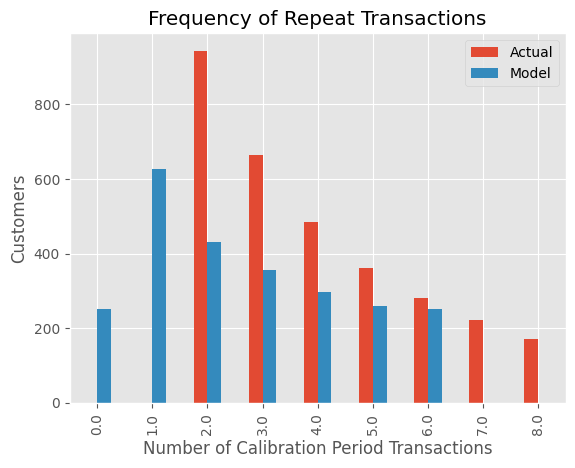

In [35]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef = 0.001)
bgf.fit(rfmt_df["F"], rfmt_df["R"], rfmt_df["T"])
print(bgf)
bgf.summary

from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf);

---
---

Forecast Model Builing

In [37]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

sheet1_data = pd.read_excel('../data/online_retail_II.xlsx', sheet_name='Year 2009-2010')
sheet2_data = pd.read_excel('../data/online_retail_II.xlsx', sheet_name='Year 2010-2011')

In [38]:
retail_df = pd.concat([sheet1_data, sheet2_data], ignore_index=True)
num_rows = retail_df.shape[0]
num_cols = retail_df.shape[1]
(num_rows, num_cols)

(1067371, 8)

In [39]:
def preprocess_dataframe(dataframe):
    """
    Preprocesses the dataframe by handling missing values, changing datatypes,
    filtering data, and creating new columns.
    
    Args:
    - dataframe (pd.DataFrame): The input dataframe to be processed.
    
    Returns:
    - pd.DataFrame: The preprocessed dataframe.
    """
    dataframe = dataframe.copy()
    # Delete rows with missing Customer ID
    dataframe = dataframe.drop(dataframe[dataframe['Customer ID'].isnull()].index).reset_index(drop=True)

    # Changing the datatype of Customer ID to int
    dataframe['Customer ID'] = pd.to_numeric(dataframe['Customer ID'], downcast='integer')

    # Delete orders where UnitPrice or Quantity is 0 or negative
    dataframe = dataframe[(dataframe['Quantity'] > 0) & (dataframe['Price'] > 0)]

    # Create a new column for total price
    dataframe['Total Sale'] = dataframe['Quantity'] * dataframe['Price']

    # Convert Invoice to string and filter out rows starting with 'C'
    dataframe['Invoice'] = dataframe['Invoice'].astype(str)
    dataframe = dataframe.loc[~dataframe['Invoice'].str.startswith('C', na=False)]
    
    # Drop duplicates
    dataframe.drop_duplicates(inplace=True)

    return dataframe

retail_df = preprocess_dataframe(retail_df)
num_rows2 = retail_df.shape[0]
num_cols2 = retail_df.shape[1]
# (num_rows - num_rows2, num_cols-num_cols2)

# print(f'Original shape: {(num_rows, num_cols)}\nPre-processed shape: {num_rows2, num_cols2}\nDropped: {num_rows-num_rows2} = {100*round(1-(num_rows2/num_rows),4)}%')
drop_percentage = round(100 * (1 - (num_rows2 / num_rows)),2)
dropped_rows = num_rows - num_rows2

print(f'Original shape: ({num_rows}, {num_cols})')
print(f'Processed shape: ({num_rows2}, {num_cols2})')
print(f'Dropped: {dropped_rows} rows ({drop_percentage}%)')

Original shape: (1067371, 8)
Processed shape: (779425, 9)
Dropped: 287946 rows (26.98%)


In [40]:
def compute_rfm(dataframe):
    """
    Compute the Recency, Frequency, and Monetary (RFM) values for each customer.

    Parameters:
    - dataframe (pd.DataFrame): The dataframe containing transaction data with required columns:
        * 'InvoiceDate': Date of the transaction
        * 'Invoice': Unique identifier for each transaction
        * 'Total Sale': Total sale amount for each transaction
        * 'Customer ID': Unique identifier for each customer

    Returns:
    - rfm_df (pd.DataFrame): A dataframe with RFM values for each customer, columns include:
        * 'Customer ID': Unique identifier for each customer
        * 'Recency': Days since the customer's last transaction
        * 'Frequency': Number of transactions by the customer
        * 'Monetary': Total sale amount across all of the customer's transactions
    """
    
    # Compute Monetary value for each customer
    monetary = dataframe.groupby('Customer ID')['Total Sale'].sum().reset_index()

    # Compute Frequency for each customer
    frequency = dataframe.groupby('Customer ID')['Invoice'].count().reset_index()
    frequency.columns = ['Customer ID', 'Frequency']

    # Merge monetary and frequency dataframes
    rfm_df = pd.merge(monetary, frequency, on='Customer ID', how='inner')

    # Calculate Recency for each customer
    max_transaction_date = max(dataframe['InvoiceDate'])
    dataframe['Time Since Purchase'] = max_transaction_date - dataframe['InvoiceDate']
    recency = dataframe.groupby('Customer ID')['Time Since Purchase'].min().reset_index()
    recency['Time Since Purchase'] = recency['Time Since Purchase'].dt.days

    # Merge rfm_df with recency dataframe
    rfm_df = pd.merge(rfm_df, recency, on='Customer ID', how='inner')
    rfm_df.columns = ['Customer ID', 'Total Sale', 'Frequency', 'Recency']

    return rfm_df


rfm = compute_rfm(retail_df)

# remove outliers
cols = ['Total Sale', 'Recency', 'Frequency']

for col in cols:
    Q1 = rfm[col].quantile(0.05)
    Q3 = rfm[col].quantile(0.95)
    IQR = Q3 - Q1
    rfm = rfm[(rfm[col] >= Q1-1.5*IQR) & (rfm[col] <= Q3+1.5*IQR)]

print(rfm.head())
print(rfm.shape)


   Customer ID  Total Sale  Frequency  Recency
1        12347     4921.53        222        1
2        12348     2019.40         51       74
3        12349     4428.69        175       18
4        12350      334.40         17      309
5        12351      300.93         21      374
(5762, 4)


# Scale the data

In [41]:
from sklearn.preprocessing import StandardScaler

rfm_normalized = rfm[['Recency', 'Frequency', 'Total Sale']]
scaler = StandardScaler()

# fit_transform
rfm_normalized = scaler.fit_transform(rfm_normalized)

# Convert back to a DataFrame and assign column names
rfm_normalized = pd.DataFrame(rfm_normalized, columns=['Recency', 'Frequency', 'Total Sale'])

# 
# plot_boxplots(rfm_normalized, cols)
print(rfm_normalized.head())
print(rfm_normalized.shape)

   Recency  Frequency  Total Sale
0    -0.97       0.76        1.06
1    -0.62      -0.38        0.05
2    -0.88       0.45        0.89
3     0.50      -0.60       -0.54
4     0.81      -0.58       -0.55
(5762, 3)


## <span style="color:teal;">KMeans</span>

KMeans is one of the simplest and most widely used unsupervised machine learning algorithms. It aims to partition a set of data points into `k` distinct clusters, where each data point belongs to the cluster with the nearest mean.

### <span style="color:teal;">Use Case for KMeans</span>

KMeans is commonly employed in market segmentation, where businesses categorize their customers based on purchasing behavior, demographics, or other features. This enables businesses to tailor their strategies and products to better fit each segment, optimizing customer satisfaction and revenue.


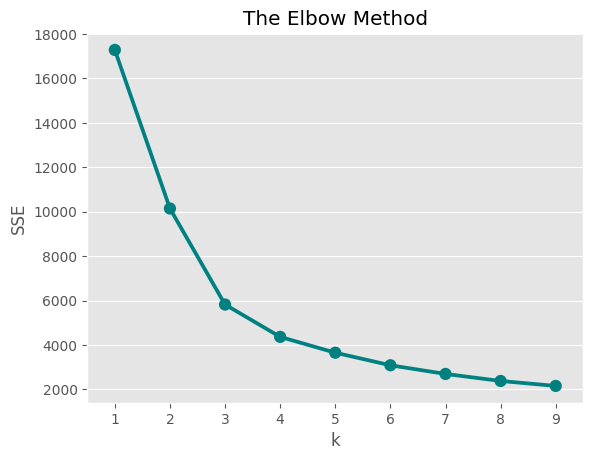

In [42]:
# Elbow method

# Fit KMeans and calculate SSE for each *k*
sse = {}
# Fit KMeans and calculate SSE for each k
for k in range(1, 10):
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1, n_init=10)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(rfm_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_ 
    
plt.style.use('ggplot')
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()), color='teal')
plt.show()

### <span style="color:teal;">Elbow Method Analysis</span>

As we increase the number of clusters, the SSE (Sum of Squared Errors) tends to decrease. The optimal value for 'k' (number of clusters) is typically where the decrease in SSE starts to level off, forming an "elbow". From the given graph:

- The "elbow" is clearly noticeable at `k=3`.
- Beyond `k=3`, there's a diminishing return in terms of clustering compactness.

**Conclusion:** Based on the Elbow Method, `k=3` is the most suitable choice for the number of clusters in KMeans clustering for this data.


In [43]:
clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in clusters:
    model = KMeans(n_clusters=num_clusters, random_state=1, n_init=10, max_iter=50)
    model.fit(rfm_normalized)
    cluster_labels = model.labels_
    
    # Silhouette score
    silhouette_avg = silhouette_score(rfm_normalized, cluster_labels)
    print("For n_clusters={}, the silhouette score is {}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5492062869551888
For n_clusters=3, the silhouette score is 0.49995299561287926
For n_clusters=4, the silhouette score is 0.493093767185679
For n_clusters=5, the silhouette score is 0.4896272432024691
For n_clusters=6, the silhouette score is 0.44513119584364175
For n_clusters=7, the silhouette score is 0.44327440868555346
For n_clusters=8, the silhouette score is 0.40515970640250004


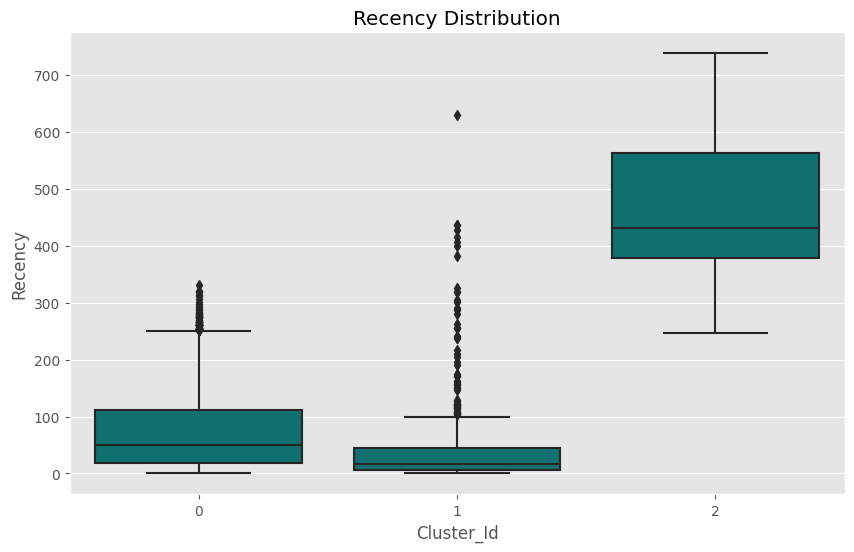

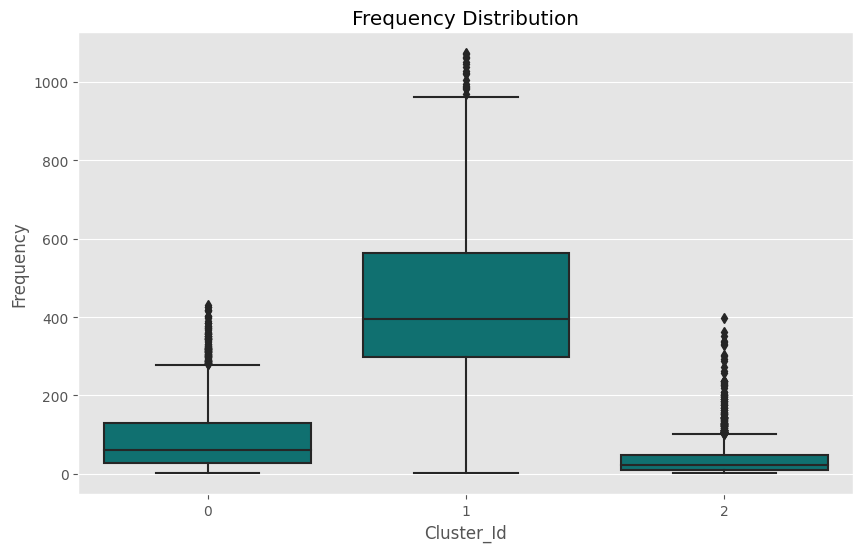

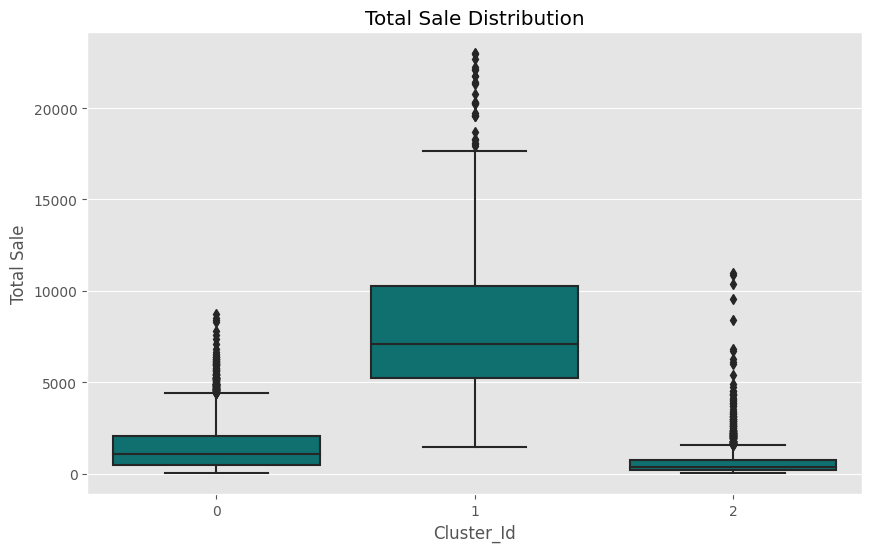

(779425, 10)


In [44]:
model = KMeans(n_clusters=3, random_state=1, max_iter=50, n_init=10)
model.fit(rfm_normalized)
rfm['Cluster_Id'] = model.labels_

# Plotting
cols = ['Recency', 'Frequency', 'Total Sale']
for col in cols:
    plt.figure(figsize=(10, 6))
    plt.title(f'{col} Distribution')
    sns.boxplot(x='Cluster_Id', y=col, data=rfm, color='teal')
    plt.show()
    
print(retail_df.shape)

### <span style="color:teal;">Recency Distribution Across Clusters</span>

Analyzing the box plots for each cluster:

- **Cluster 0**: Displays low recency values, suggesting these customers have recently interacted or made a purchase.
- **Cluster 1**: Contains a mix with several outliers, but primarily has low recency values, similar to Cluster 0.
- **Cluster 2**: Represents customers with a higher recency, meaning it's been a longer time since their last interaction or purchase.

**Conclusion:** Cluster 0 and 1 comprise mostly of recent customers, while Cluster 2 represents less recent ones.


### <span style="color:teal;">Frequency Distribution Across Clusters</span>

Upon observing the box plots for frequency distribution across clusters:

- **Cluster 0**: Presents a narrower range of lower frequencies, implying these customers don't interact or purchase as often.
- **Cluster 1**: Displays a broader range of frequency values, indicating these customers have varying interaction or purchase rates, some of them quite frequent.
- **Cluster 2**: Consists mainly of lower frequencies, similar to Cluster 0, but with several outliers at higher frequencies.

**Conclusion:** Cluster 1 contains the most frequent customers, while Clusters 0 and 2 generally consist of less frequent customers.


### <span style="color:teal;">Total Sale Distribution Across Clusters</span>

From the box plots illustrating the distribution of total sales across clusters:

- **Cluster 0**: Shows a compact distribution around lower total sales values, suggesting these customers spend relatively less.
- **Cluster 1**: Features a wider distribution, primarily around medium to high total sales. It suggests a mixed group of customers in terms of expenditure.
- **Cluster 2**: Mainly hovers around lower total sales, similar to Cluster 0, but possesses several outliers indicating sporadic high spenders.

**Conclusion:** Cluster 1 tends to have customers who contribute more to total sales, whereas Clusters 0 and 2 primarily consist of lower spenders with few exceptions in Cluster 2.



In [45]:
rfm.head()

Customer ID  Total Sale  Frequency  Recency  Cluster_Id
1        12347     4921.53        222        1           0
2        12348     2019.40         51       74           0
3        12349     4428.69        175       18           0
4        12350      334.40         17      309           2
5        12351      300.93         21      374           2

In [46]:
customer_cluster_map = rfm.set_index('Customer ID')['Cluster_Id'].to_dict()
print(customer_cluster_map)

{12347: 0, 12348: 0, 12349: 0, 12350: 2, 12351: 2, 12352: 0, 12353: 0, 12354: 0, 12355: 0, 12356: 0, 12357: 1, 12358: 0, 12359: 1, 12360: 0, 12361: 2, 12362: 1, 12363: 0, 12364: 0, 12365: 2, 12366: 2, 12367: 0, 12368: 2, 12369: 2, 12370: 0, 12371: 0, 12372: 0, 12373: 2, 12374: 0, 12375: 0, 12376: 2, 12377: 0, 12378: 1, 12379: 0, 12380: 1, 12381: 0, 12383: 0, 12384: 0, 12385: 2, 12386: 2, 12387: 2, 12388: 0, 12389: 2, 12390: 0, 12391: 0, 12392: 2, 12393: 0, 12394: 0, 12395: 0, 12396: 2, 12397: 0, 12398: 0, 12399: 0, 12400: 2, 12401: 2, 12402: 2, 12403: 0, 12404: 2, 12405: 0, 12406: 0, 12407: 0, 12408: 0, 12410: 2, 12411: 2, 12412: 0, 12413: 0, 12414: 0, 12416: 2, 12417: 1, 12418: 0, 12419: 2, 12420: 0, 12421: 0, 12422: 0, 12423: 0, 12424: 0, 12425: 0, 12426: 0, 12427: 0, 12428: 1, 12429: 0, 12430: 0, 12431: 1, 12432: 0, 12433: 1, 12434: 0, 12435: 1, 12436: 0, 12437: 1, 12438: 0, 12439: 2, 12440: 2, 12441: 2, 12442: 0, 12443: 2, 12444: 0, 12445: 0, 12446: 0, 12447: 0, 12448: 0, 12449: 0,

In [47]:
retail_df['Cluster_Id'] = retail_df['Customer ID'].map(customer_cluster_map)
retail_df.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  Total Sale  \
0 2009-12-01 07:45:00   6.95        13085  United Kingdom       83.40   
1 2009-12-01 07:45:00   6.75        13085  United Kingdom       81.00   
2 2009-12-01 07:45:00   6.75        13085  United Kingdom       81.00   
3 2009-12-01 07:45:00   2.10        13085  United Kingdom      100.80   
4 2009-12-01 07:45:00   1.25        13085  United Kingdom       30.00   

  Time Since Purchase  Cluster_Id  
0   738 days 05:05:00        0.00  
1   738 days 05:05:00        0.00  
2   738 days 05:05:00        0.00  
3   738 days 05:05:00        0.00  
4   738 days 05:05:00        0.00

In [48]:
retail_df2 = retail_df.copy()
print(retail_df2['Cluster_Id'].isna().sum()) # 158949

# Drop rows where 'Cluster_Id' is NaN
retail_df2 = retail_df2.dropna(subset=['Cluster_Id'])
# # Drop rows where 'Cluster_Id' is empty
retail_df2 = retail_df2[retail_df2['Cluster_Id'] != ""]
retail_df2["Cluster_Id"] = retail_df2["Cluster_Id"].astype(int)
retail_df2.isna().sum()

158949


Invoice                0
StockCode              0
Description            0
Quantity               0
InvoiceDate            0
Price                  0
Customer ID            0
Country                0
Total Sale             0
Time Since Purchase    0
Cluster_Id             0
dtype: int64

In [49]:
def split_data_by_cluster(dataframe):
    """
    Splits the dataframe by distinct 'Cluster_Id' values.
    
    Args:
    - dataframe (pd.DataFrame): The input dataframe with a 'Cluster_Id' column.

    Returns:
    - dict of pd.DataFrame: A dictionary where keys are the distinct 'Cluster_Id' values and values are the corresponding dataframes.
    """
    clusters = dataframe['Cluster_Id'].unique()
    cluster_dataframes = {}

    for cluster in clusters:
        cluster_dataframes[cluster] = dataframe[dataframe['Cluster_Id'] == cluster]
        print(f"cluster{cluster}.shape:", cluster_dataframes[cluster].shape)

    return cluster_dataframes

# Usage
cluster_dataframes = split_data_by_cluster(retail_df2)
cluster0 = cluster_dataframes[0]
cluster1 = cluster_dataframes[1]
cluster2 = cluster_dataframes[2]


cluster0.shape: (286149, 11)
cluster2.shape: (73660, 11)
cluster1.shape: (260667, 11)


In [50]:
cluster0.head()

Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  Total Sale  \
0 2009-12-01 07:45:00   6.95        13085  United Kingdom       83.40   
1 2009-12-01 07:45:00   6.75        13085  United Kingdom       81.00   
2 2009-12-01 07:45:00   6.75        13085  United Kingdom       81.00   
3 2009-12-01 07:45:00   2.10        13085  United Kingdom      100.80   
4 2009-12-01 07:45:00   1.25        13085  United Kingdom       30.00   

  Time Since Purchase  Cluster_Id  
0   738 days 05:05:00           0  
1   738 days 05:05:00           0  
2   738 days 05:05:00           0  
3   738 days 05:05:00           0  
4   738 days 05:05:00           0

In [51]:
def process_data(dataframe):
    """
    Process the input dataframe by performing a series of operations.
    
    Parameters:
    - dataframe (DataFrame): Input dataframe to process
    
    Returns:
    - DataFrame: Processed dataframe
    """
    dataframe = dataframe.copy() 
    
    # Convert 'InvoiceDate' to datetime format and truncate the minutes part
    # dataframe['InvoiceDate'] = pd.to_datetime(dataframe['InvoiceDate']).dt.date
    dataframe['InvoiceDate'] = pd.to_datetime(dataframe['InvoiceDate'])
    dataframe['InvoiceDate'] = dataframe['InvoiceDate'].dt.date

    # Drop unnecessary columns if they exist
    columns_to_drop = ['Customer ID', 'Price']
    dataframe.drop(columns=[col for col in columns_to_drop if col in dataframe.columns], inplace=True)

    # Group by 'InvoiceDate' and 'Cluster_Id' and aggregate Quantity and TotalPrice
    grouped_data = dataframe.groupby(['InvoiceDate', 'Cluster_Id']).agg({
        'Quantity': 'sum',
        'Total Sale': 'sum'
    }).reset_index()

    # Remove outliers in 'Quantity' and 'TotalPrice' columns
    for column in ['Quantity', 'Total Sale']:
        z_scores = stats.zscore(grouped_data[column])
        grouped_data = grouped_data[np.abs(z_scores) < 3]

    return grouped_data


# usage
cluster0_processed_df = process_data(cluster0)
print(cluster0_processed_df.shape)
print(cluster0_processed_df.head())

cluster1_processed_df = process_data(cluster1)
print(cluster1_processed_df.shape)
print(cluster1_processed_df.head())

cluster2_processed_df = process_data(cluster2)
print(cluster2_processed_df.shape)
print(cluster2_processed_df.head())

(589, 4)
  InvoiceDate  Cluster_Id  Quantity  Total Sale
0  2009-12-01           0      4832     8903.82
1  2009-12-02           0      6150    10356.74
2  2009-12-03           0      5955    10779.39
3  2009-12-04           0      2869     4649.72
4  2009-12-05           0      2260     3973.22
(595, 4)
  InvoiceDate  Cluster_Id  Quantity  Total Sale
0  2009-12-01           1      6322    12457.55
1  2009-12-02           1      9526    15374.59
2  2009-12-03           1      7435    14260.41
3  2009-12-04           1      9485    15448.02
4  2009-12-05           1      1055     1958.63
(386, 4)
  InvoiceDate  Cluster_Id  Quantity  Total Sale
0  2009-12-01           2      5825     7062.68
1  2009-12-02           2      2312     4966.30
2  2009-12-03           2      3348     6240.41
3  2009-12-04           2      2559     5235.30
4  2009-12-05           2      1126     1568.80


### <span style="color:teal;">Extract Time Features for the Model</span>

In [52]:
def extract_time_features(dataframe):
    """
    Extract time-based features from 'InvoiceDate' column of the input dataframe.
    
    Parameters:
    - dataframe (DataFrame): Input dataframe from which to extract features.
    
    Returns:
    - DataFrame: Dataframe with extracted time-based features.
    """
    
    # Ensure 'InvoiceDate' is in datetime format
    dataframe['InvoiceDate'] = pd.to_datetime(dataframe['InvoiceDate'])

    # Extract time-based features
    dataframe['Week'] = dataframe['InvoiceDate'].dt.isocalendar().week
    dataframe['Weekday'] = dataframe['InvoiceDate'].dt.weekday
    dataframe['Day'] = dataframe['InvoiceDate'].dt.day
    dataframe['Weekend'] = dataframe['Weekday'].isin([5, 6]).astype(int)

    return dataframe

cluster0_processed_df = extract_time_features(cluster0_processed_df)
cluster1_processed_df = extract_time_features(cluster1_processed_df)
cluster2_processed_df = extract_time_features(cluster2_processed_df)

In [53]:
print(cluster0_processed_df.shape)
print(cluster0_processed_df.head())

print(cluster1_processed_df.shape)
print(cluster1_processed_df.head())

print(cluster2_processed_df.shape)
print(cluster2_processed_df.head())

(589, 8)
  InvoiceDate  Cluster_Id  Quantity  Total Sale  Week  Weekday  Day  Weekend
0  2009-12-01           0      4832     8903.82    49        1    1        0
1  2009-12-02           0      6150    10356.74    49        2    2        0
2  2009-12-03           0      5955    10779.39    49        3    3        0
3  2009-12-04           0      2869     4649.72    49        4    4        0
4  2009-12-05           0      2260     3973.22    49        5    5        1
(595, 8)
  InvoiceDate  Cluster_Id  Quantity  Total Sale  Week  Weekday  Day  Weekend
0  2009-12-01           1      6322    12457.55    49        1    1        0
1  2009-12-02           1      9526    15374.59    49        2    2        0
2  2009-12-03           1      7435    14260.41    49        3    3        0
3  2009-12-04           1      9485    15448.02    49        4    4        0
4  2009-12-05           1      1055     1958.63    49        5    5        1
(386, 8)
  InvoiceDate  Cluster_Id  Quantity  Total Sale  

Train test split the data on date

I will be forecasting the last 2 months of sales due to having limited data

In [54]:
def train_test_split_on_date(dataframe, split_date='2011-10-01', date_column='InvoiceDate', target='Total Sale'):
    """
    Split the dataframe into train and test sets based on a specific date.

    Parameters:
    - dataframe (DataFrame): The dataframe to split.
    - split_date (str): The date to split on.
    - date_column (str): The column containing dates.
    - target (str): The target column.

    Returns:
    - DataFrame, DataFrame, Series, Series, Series, Series: Train and test datasets without the target and corresponding targets.
    """
    
    train_data = dataframe[dataframe[date_column] < split_date]
    test_data = dataframe[dataframe[date_column] >= split_date]

    X_train, y_train = train_data.drop(columns=[date_column, target]), train_data[target]
    X_test, y_test = test_data.drop(columns=[date_column, target]), test_data[target]
    
    return X_train, X_test, y_train, y_test, train_data, test_data


### <span style="color:teal;">Model to Forecast Sales: XGBRegressor</span>

XGBRegressor is a part of the XGBoost (Extreme Gradient Boosting) library, which is an optimized gradient boosting machine learning library. It's designed for regression tasks where the objective is to predict a continuous value.

### <span style="color:teal;">Benefits of Using XGBRegressor</span>

1. **Efficiency and Speed:** XGBoost is optimized for performance. It can handle large datasets quickly.
2. **Handling Missing Data:** XGBoost can automatically handle missing values, reducing the need for imputation.
3. **Regularization:** XGBoost includes L1 (Lasso) and L2 (Ridge) regularization which can prevent overfitting.
4. **Tree Pruning:** Unlike other gradient boosting techniques, XGBoost grows the tree to a specified max_depth and then prunes it, improving computational efficiency.
5. **Cross-validation:** XGBoost has an in-built routine to perform cross-validation, aiding in tuning the model.
6. **Flexibility:** It allows users to define custom optimization objectives and evaluation criteria, making it adaptable to different regression problems.
7. **Parallel and Distributed Processing:** XGBoost can be run on a multi-core machine or distributed environment, speeding up the training process.
8. **Feature Importance:** XGBoost provides feature importance scores, aiding in feature selection and understanding the influence of each feature on predictions.


### <span style="color:teal;">Evaluation Metrics: R-Squared and RMSE</span>

**R-Squared (Coefficient of Determination)**:
- **Definition**: R-Squared measures the proportion of variance in the dependent variable that is predictable from the independent variables.
- **Utility**: It provides insight into how well the model's predictions align with the actual values. A value closer to 1 implies the model explains a large fraction of the variance in the response variable.
- **In the Context of XGBRegressor**: Due to the boosting technique employed by XGBoost, a high R-Squared value suggests that the model has captured complex patterns and relationships in the dataset.

**Root Mean Square Error (RMSE)**:
- **Definition**: RMSE calculates the square root of the average squared differences between the observed actual outturn values and the values predicted by the model.
- **Utility**: It gives a direct indication of the model's prediction accuracy in the unit of the dataset. A lower RMSE value denotes better prediction accuracy.
- **In the Context of XGBRegressor**: XGBoost is designed to minimize loss, and a reduced RMSE demonstrates the model's effectiveness in achieving this goal. It also offers a sense of the average error magnitude the model makes.

In [55]:
def train_xgboost(X_train, y_train, X_test, y_test, train, test):
    """
    Train an XGBoost regressor using GridSearchCV for hyperparameter tuning, and plot the predictions.

    Parameters:
    - X_train, y_train: Training data and corresponding labels
    - X_test, y_test: Testing data and corresponding labels
    - retail_train, retail_test: Original train and test dataframes

    Returns:
    - tuple: best XGBoost model, its R^2 score on the test data, RMSE, and the combined dataframe with predictions
    """

    # Diversified parameter grid for XGBoost
    params = {
        'min_child_weight': [4, 5, 6],
        'gamma': [0.3, 0.4, 0.5], # regularization: 
        'subsample': [0.7, 0.8, 0.9],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'max_depth': [3, 4, 5],
        'alpha': [0.01, 0.1, 1], # L1(Lasso regression) regularization
        'lambda': [0.01, 0.1, 1], # L2(Ridge regression) regularization
        'eval_metric': ['rmse'],
        'early_stopping_rounds': [10]  
    }

    # Define custom scorers
    def custom_r2_scorer(y_true, y_pred):
        return r2_score(y_true, y_pred)

    def custom_rmse_scorer(y_true, y_pred):
        return -np.sqrt(mean_squared_error(y_true, y_pred))  # Negate as GridSearchCV tries to maximize

    scoring = {
        'r2': make_scorer(custom_r2_scorer, greater_is_better=True),
        'rmse': make_scorer(custom_rmse_scorer, greater_is_better=False)
    }

    # Initialize XGBRegressor with the objective 'reg:squarederror'
    xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')

    # Initialize GridSearchCV with multiple scorers
    grid = GridSearchCV(xgb_reg, params, scoring=scoring, refit='r2', return_train_score=True, verbose=1)

    # Fit the model with early stopping
    eval_set = [(X_train, y_train), (X_test, y_test)]
    grid.fit(X_train, y_train, eval_set=eval_set, verbose=False)

    # Print scores for each hyperparameter combination
    for mean_test_r2, mean_train_r2, mean_test_rmse, mean_train_rmse, params in zip(
            grid.cv_results_['mean_test_r2'],
            grid.cv_results_['mean_train_r2'],
            grid.cv_results_['mean_test_rmse'],
            grid.cv_results_['mean_train_rmse'],
            grid.cv_results_['params']):
        print(f"Params: {params}")
        print(f"Train R^2 Score: {mean_train_r2}, Test R^2 Score: {mean_test_r2}")
        print(f"Train RMSE: {-mean_train_rmse}, Test RMSE: {-mean_test_rmse}")
        print("---------------------------------------------------------")

    # Get the best estimator
    gridcv_xgb = grid.best_estimator_

    # Predict on the test set and calculate R^2 score and RMSE
    predictions = gridcv_xgb.predict(X_test)
    score = r2_score(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    

    # Extract best scores from grid.cv_results_
    best_index = grid.best_index_
    best_train_r2 = grid.cv_results_['mean_train_r2'][best_index]
    best_test_r2 = grid.cv_results_['mean_test_r2'][best_index]
    best_train_rmse = -grid.cv_results_['mean_train_rmse'][best_index]  # -1 because we negated the RMSE during scoring
    best_test_rmse = -grid.cv_results_['mean_test_rmse'][best_index] 

    # Output the final model results
    print("Final Model Results:")
    print("Best Parameters:", grid.best_params_)
    print(f"Train R^2 Score: {best_train_r2}")
    print(f"Test R^2 Score: {best_test_r2}")
    print(f"Train RMSE: {best_train_rmse}")
    print(f"Test RMSE: {best_test_rmse}")

    test_copy = test.copy()
    test_copy['Prediction'] = predictions

    # Combine test and train data
    combined_df = pd.concat([test_copy, train], sort=False)

    # ! Plotting (testing this)
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(15, 5))
    sns.lineplot(x=train.index, y=train['Total Sale'], label='Total Sale', color='teal', linewidth=1, ax=ax)
    sns.lineplot(x=test_copy.index, y=test_copy['Total Sale'], color='teal', linewidth=1, ax=ax)
    sns.lineplot(x=test_copy.index, y=test_copy['Prediction'], label='Prediction', color='salmon', linewidth=1, ax=ax)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    plt.show()

    # Plot feature importance
    plt.figure(figsize=(15, 7))
    xgb.plot_importance(gridcv_xgb, importance_type='weight', ax=plt.gca(), show_values=False)
    plt.title("Feature Importance")
    plt.show()

    return gridcv_xgb, score, rmse, combined_df


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Params: {'alpha': 0.01, 'colsample_bytree': 0.7, 'early_stopping_rounds': 10, 'eval_metric': 'rmse', 'gamma': 0.3, 'lambda': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7}
Train R^2 Score: 0.9421961350537545, Test R^2 Score: 0.8210212639540195
Train RMSE: -829.0181426777037, Test RMSE: -1214.4968319946925
---------------------------------------------------------
Params: {'alpha': 0.01, 'colsample_bytree': 0.7, 'early_stopping_rounds': 10, 'eval_metric': 'rmse', 'gamma': 0.3, 'lambda': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.8}
Train R^2 Score: 0.9446958042143532, Test R^2 Score: 0.8142530576096346
Train RMSE: -811.0095474148505, Test RMSE: -1253.901492896636
---------------------------------------------------------
Params: {'alpha': 0.01, 'colsample_bytree': 0.7, 'early_stopping_rounds': 10, 'eval_metric': 'rmse', 'gamma': 0.3, 'lambda': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'su

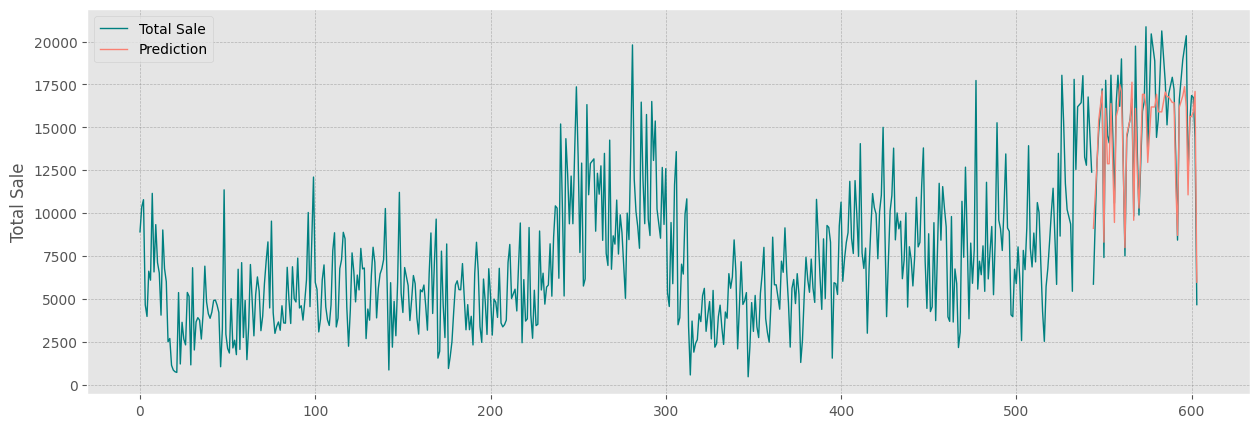

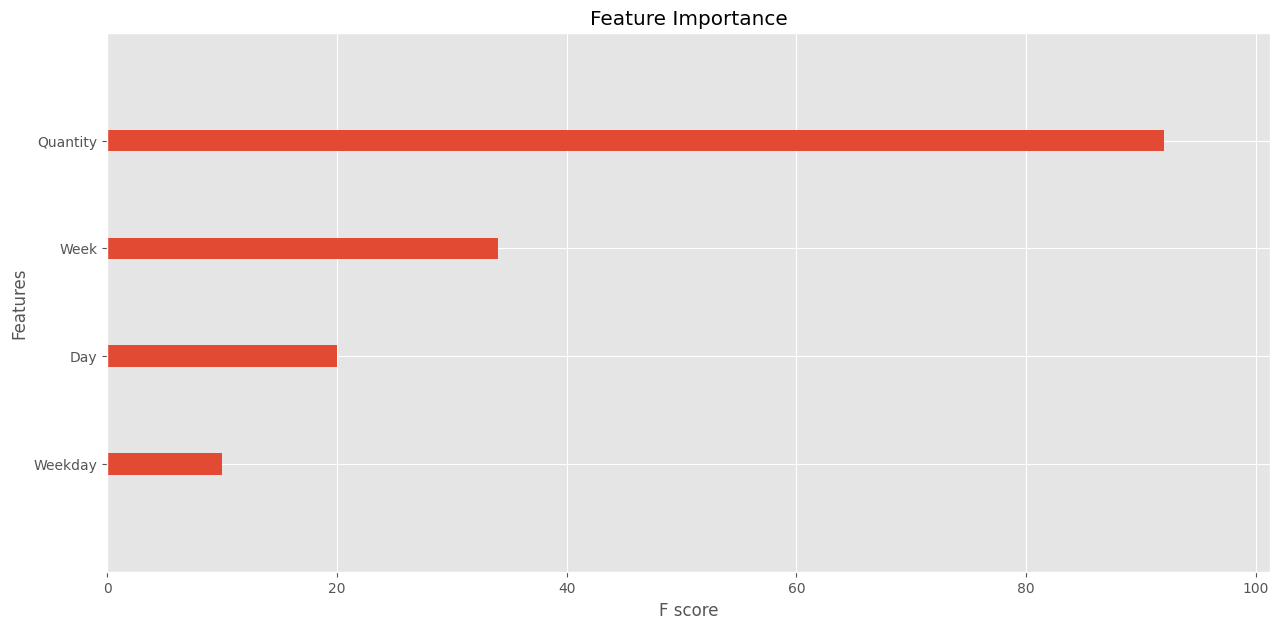

In [56]:

# ! needs to be done for each cluster
# * cluster0_processed_df:
X_train, X_test, y_train, y_test, train, test = train_test_split_on_date(cluster0_processed_df)
best_model, r2, rmse_val, combined_df = train_xgboost(X_train, y_train, X_test, y_test, train, test)

### <span style="color:teal;">Evaluation Metrics for Cluster0</span>

**R-Squared (Coefficient of Determination)**:
- **Train R^2 Score**: 0.9458
  - This score indicates that approximately 94.58% of the variance in the dependent variable is predictable from the independent variables in the training set.
- **Test R^2 Score**: 0.8543
  - This score shows that about 85.43% of the variance in the dependent variable is predictable from the independent variables in the test set.

**Root Mean Square Error (RMSE)**:
- **Train RMSE**: 805.18
  - This value represents the average error magnitude between the model's predictions and actual values in the training set. The absolute value is taken here because GridSearchCV uses a convention where it tries to maximize the score, so it maximizes negative MSE which leads to negative RMSE values. 
- **Test RMSE**: 1119.69
  - This value signifies the average error magnitude between the model's predictions and actual values in the test set. The absolute value is reported for the same reason as above.

### <span style="color:teal;">Feature Importance Analysis</span>

The chart visualizes the relative importance of features used in the model. The importance is represented by the "F score", a metric that denotes the number of times a feature is split on.

**Observations**:

- **Quantity**: This feature has the highest importance, with an F score close to 100. This suggests that 'Quantity' plays a pivotal role in influencing the model's predictions.
  
- **Week**: With an F score around 40, the 'Week' feature also contributes notably to the model's decisions, although not as significantly as 'Quantity'.
  
- **Day**: This feature has an intermediate importance with an F score slightly above 20.
  
- **Weekday**: The 'Weekday' feature has the least importance among the presented features, with an F score just below 20.

The insights from this chart can help in understanding which features are most influential in making predictions and can guide feature engineering efforts for potential model improvements.


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Params: {'alpha': 0.01, 'colsample_bytree': 0.7, 'early_stopping_rounds': 10, 'eval_metric': 'rmse', 'gamma': 0.3, 'lambda': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7}
Train R^2 Score: 0.9077609400943578, Test R^2 Score: 0.8199767848670181
Train RMSE: -1066.3049305827112, Test RMSE: -1397.2917447278874
---------------------------------------------------------
Params: {'alpha': 0.01, 'colsample_bytree': 0.7, 'early_stopping_rounds': 10, 'eval_metric': 'rmse', 'gamma': 0.3, 'lambda': 0.01, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.8}
Train R^2 Score: 0.9148574144417001, Test R^2 Score: 0.8184633602272868
Train RMSE: -1022.7494258259176, Test RMSE: -1403.0250723484394
---------------------------------------------------------
Params: {'alpha': 0.01, 'colsample_bytree': 0.7, 'early_stopping_rounds': 10, 'eval_metric': 'rmse', 'gamma': 0.3, 'lambda': 0.01, 'max_depth': 3, 'min_child_weight': 4, 

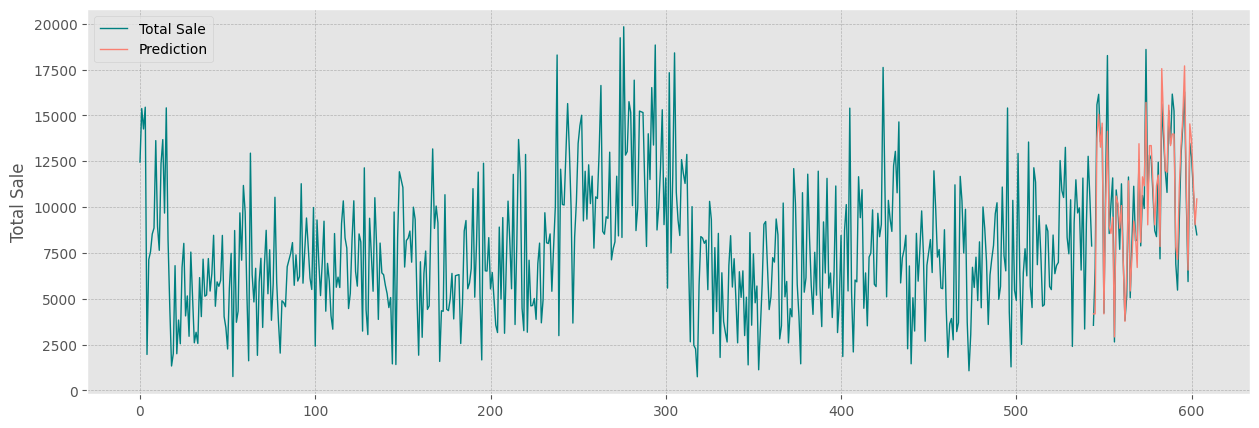

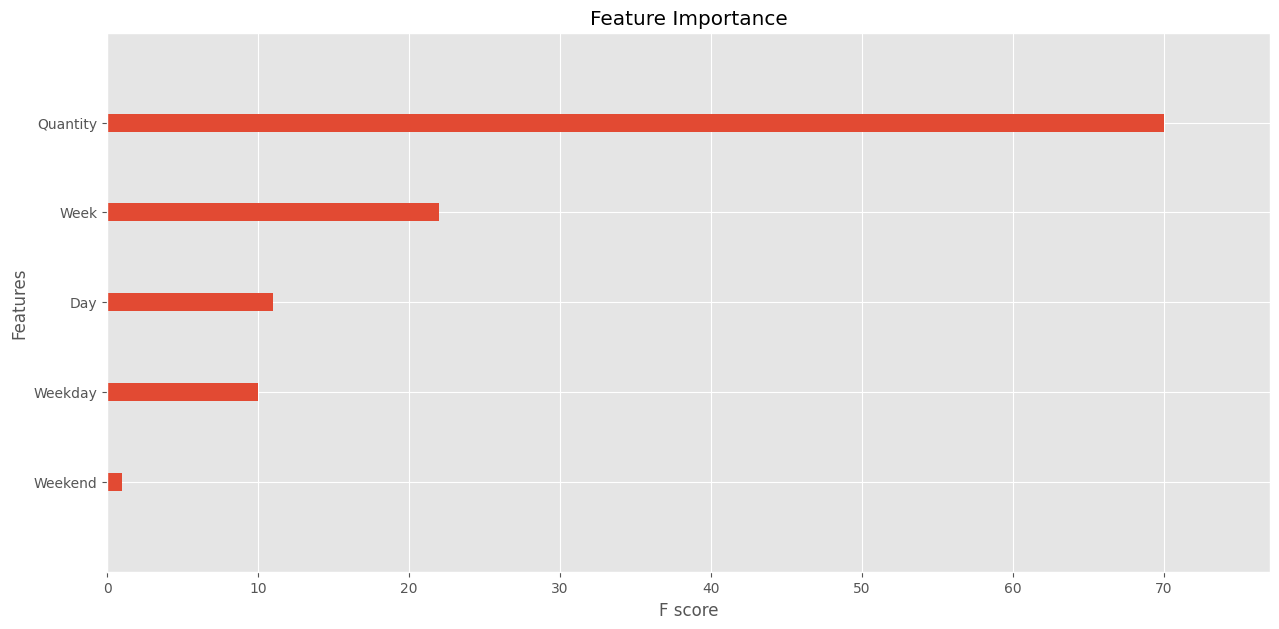

In [57]:

# ! needs to be done for each cluster
# * cluster1_processed_df:
X_train, X_test, y_train, y_test, train, test = train_test_split_on_date(cluster1_processed_df)
best_model, r2, rmse_val, combined_df = train_xgboost(X_train, y_train, X_test, y_test, train, test)

### <span style="color:teal;">Evaluation Metrics Cluster1</span>

**R-Squared (Coefficient of Determination)**:
- **Train R^2 Score**: 0.9015
  - This score indicates that approximately 90.15% of the variance in the dependent variable is predictable from the independent variables in the training set.
- **Test R^2 Score**: 0.8399
  - This score shows that about 83.99% of the variance in the dependent variable is predictable from the independent variables in the test set.

**Root Mean Square Error (RMSE)**:
- **Train RMSE**: 1099.71
  - This value represents the average error magnitude between the model's predictions and actual values in the training set. The absolute value is taken here because GridSearchCV uses a convention where it tries to maximize the score, so it maximizes negative MSE which leads to negative RMSE values. 
- **Test RMSE**: 1312.34
  - This value signifies the average error magnitude between the model's predictions and actual values in the test set. The absolute value is reported for the same reason as above.

### <span style="color:teal;">Feature Importance Analysis</span>

Similar to that of Cluster0.


## <span style="color:teal;">Discussion on Model Overfitting</span>

Based on the evaluation metrics, the model demonstrates better performance on the training data compared to the test data. This discrepancy is indicative of overfitting. However, there are still justifiable reasons for considering this model, along with suggestions for improvements:

#### **1. Acceptable Test Scores**:
- Despite the discrepancy, the test scores are still relatively high, indicating that the model can capture a substantial proportion of the variance in the data. As a result, it can be deemed useful in real-world applications where one can predict outcomes with a margin of error.


#### **2. Model Complexity**:
- Complex models like XGBRegressor can capture intricate patterns in the data. This complexity is a double-edged sword; it can lead to better predictions but also to overfitting. Understanding this trade-off is essential.

#### **Possible Improvements**:
1. **Feature Engineering**: Refining or adding more relevant features can help the model generalize better. At the same time, removing irrelevant or noise-inducing features can prevent overfitting.
2. **Gathering More Data**: If feasible, acquiring more data can always help in making the model more robust and generalizable.

In conclusion, while the observed overfitting is a concern, it doesn't invalidate the utility of the model. With the right adjustments and considerations, the model's performance can be enhanced, making it more suitable for deployment in real-world scenarios.


# **<span style="color:teal;">Conclusion</span>**

The analysis presented shed light on several aspects of the challenge. Some key takeaways and difficulties encountered are:

#### **1. Data Limitations**:
- One of the primary obstacles faced was the limitation in available data. A more comprehensive dataset, both in terms of temporal scope and the range of features, would have greatly aided the analysis. For instance, the inclusion of additional customer demographics or product promotions could have offered deeper insights. - In retrospect, this methodology may have made the model more complex than it might've been by simply applys KMEANS and forecasting.
- This constraint impacted the KMEANS model, especially for the 3rd cluster. Due to the lack of data for the forecast period, the model couldn't function as anticipated.

#### **2. Recommendations for Future Work**:
1. **Alternative Segmentation Approaches**: Future explorations could benefit from investigating different methodologies for customer segmentation. Utilizing NLP to segment based on products and delving into graph theory within those segments are two promising avenues.
2. **Tuning the CLTV Models**: The Customer Lifetime Value (CLTV) models developed using Yellowbrick possess significant potential. By fine-tuning these models, businesses can gain a better understanding of sales predictions on a per-customer basis. Furthermore, it may provide insights into the probability of a customer making a purchase within specific time windows.

In wrapping up, while there were challenges, the findings offer a foundation for further analysis. By addressing the identified constraints and incorporating the recommended approaches, future studies can yield even more valuable insights for businesses.

